## Importar Librerías Estándares

In [1]:
import pandas as pd
import numpy as np
import statistics as stat
import gc

## Declarar Funciones

In [2]:
def get_rcc():
    rcc_train = pd.read_csv(f'{path}/rcc_train.csv')
    rcc_test = pd.read_csv(f'{path}/rcc_test.csv')
    ##### inputar datos faltantes en la base de rcc_test
    rcc_test['cod_instit_financiera'].fillna(rcc_test['cod_instit_financiera'].value_counts().index[0], inplace=True)
    rcc_test['PRODUCTO'].fillna(rcc_test['PRODUCTO'].value_counts().index[0], inplace=True)

    dict_ = {'codmes': 'int32',
     'key_value': 'int32',
     'condicion': 'int32',
     'tipo_credito': 'int32',
     'cod_instit_financiera': 'int32',
     'PRODUCTO': 'int32',
     'RIESGO_DIRECTO': 'int32',
     'COD_CLASIFICACION_DEUDOR': 'int32'}
    rcc_train = rcc_train.astype(dict_)
    rcc_test = rcc_test.astype(dict_)
    return rcc_train, rcc_test

In [3]:
def get_rcc_list(df, desde, n):
    rcc_list=[]
    for feature in ['cod_instit_financiera','PRODUCTO']:
        rcc_list.append(get_unstack(df, feature, desde, n, 'Sum'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Unique'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Min'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Max'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Std'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Mean'))
        rcc_list.append(get_unstack(df, feature, desde, n, 'Median'))
    return rcc_list

In [4]:
def calculate_mode(x):
    try:
        moda=stat.mode(x)
    except:
        moda=np.nan
    return moda

In [5]:
def get_keep_columns(train, test):
    print(train.shape, test.shape)
    keep_columns = list(set(train.columns).intersection(test.columns))
    train = train[keep_columns]
    test = test[keep_columns]
    print(train.shape, test.shape)
    return  train, test

In [6]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

def cross_validation_lightgbm(train, y_train, test):
    folds = [train.index[t] for t, v in KFold(5).split(train)]
    test_probs = []
    train_probs = []
    fi = []
    for i, idx in enumerate(folds):
        print("*"*10, i, "*"*10)
        Xt = train.loc[idx]
        yt = y_train.loc[Xt.index].target

        Xv = train.drop(Xt.index)
        yv = y_train.loc[Xv.index].target

        learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, 
                       colsample_bytree=0.8,subsample=0.8, max_bin=200, learning_rate=0.1, random_state=42)
        learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                    eval_set=[(Xt, yt), (Xv, yv)], verbose=50)
        test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
        train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
        fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    train_probs = pd.concat(train_probs)
    fi = pd.concat(fi, axis=1).mean(axis=1)
    print("*" * 21)
    print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
    print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))])) 
    return test_probs, fi

In [7]:
def get_feature_selection(fi):
    zero_importance = fi[fi==0]
    aux = fi[fi>0].sort_values(ascending=False)
    keep_columns = []
    count = 0
    for feature,values in zip(aux.index, aux.values):
        count+=values
        if count<=0.99:
            keep_columns.append(feature)
            
    print(f'total de variables : {len(fi)}')
    print(f'variables con importancia acumulada al 99% : {len(keep_columns)}')
    print(f'variables con zero importancia : {len(zero_importance)}')
    return keep_columns, zero_importance

In [8]:
def get_one_hot(df, feature):
    one_hot = pd.get_dummies(df[feature])
    one_hot.columns = [feature+'_'+str(i) for i in one_hot.columns]
    return one_hot

In [9]:
def get_crosstab(df, index, feature):
    df = pd.crosstab(df[index], df[feature])
    df.columns = [f'{df.columns.name}_{i}' for i in df.columns]
    return df

In [10]:
global keep_columns_final
keep_columns_final = ['edad', 'ubigeo_mode', 'sexo_0', 'PRODUCTO_1_saldoMean_ult1meses', 'PRODUCTO_1_saldoMax_ult1meses', 'PRODUCTO_3_saldoUnique_ult12meses', 'estadocontribuyente_0', 'PRODUCTO_1_saldoSum_ult1meses', 'RIESGO_DIRECTO_1_saldoStd_ult1meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult12meses', 'PRODUCTO_8_saldoUnique_ult12meses', 'RIESGO_DIRECTO_1_saldoSum_ult1meses', 'cod_instit_financiera_34_saldoUnique_ult12meses', 'PRODUCTO_0_saldoMin_ult12meses', 'ciiu_mode', 'PRODUCTO_6_saldoSum_ult12meses', 'PRODUCTO_4_saldoStd_ult12meses', 'RIESGO_DIRECTO_1_saldoUnique_ult12meses', 'PRODUCTO_1_saldoMedian_ult1meses', 'RIESGO_DIRECTO_1_saldoMax_ult12meses', 'condicion_0_saldoUnique_ult12meses', 'PRODUCTO_8_saldoSum_ult12meses', 'PRODUCTO_1_saldoMedian_ult2meses', 'PRODUCTO_1_saldoMax_ult3meses', 'PRODUCTO_0_saldoStd_ult1meses', 'PRODUCTO_1_saldoMedian_ult3meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult1meses', 'RIESGO_DIRECTO_1_saldoMin_ult1meses', 'PRODUCTO_0_saldoStd_ult12meses', 'PRODUCTO_8_saldoMedian_ult12meses', 'PRODUCTO_0_saldoMax_ult1meses', 'ctd_veh', 'PRODUCTO_3_saldoMean_ult1meses', 'PRODUCTO_1_saldoSum_ult2meses', 'fecalta_mean', 'PRODUCTO_12_saldoMin_ult1meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult2meses', 'PRODUCTO_1_saldoStd_ult2meses', 'PRODUCTO_6_saldoMax_ult1meses', 'PRODUCTO_2_saldoUnique_ult12meses', 'fecalta_min', 'PRODUCTO_8_saldoMin_ult12meses', 'cod_instit_financiera_10_saldoStd_ult1meses', 'PRODUCTO_1_saldoStd_ult1meses', 'PRODUCTO_6_saldoMin_ult12meses', 'PRODUCTO_1_saldoSum_ult12meses', 'PRODUCTO_1_saldoMin_ult1meses', 'PRODUCTO_0_saldoMin_ult1meses', 'RIESGO_DIRECTO_1_saldoStd_ult12meses', 'RIESGO_DIRECTO_-1_saldoUnique_ult12meses', 'cod_instit_financiera_max_ult1mes', 'PRODUCTO_3_saldoMedian_ult1meses', 'PRODUCTO_1_saldoMean_ult3meses', 'rgn_4', 'cod_instit_financiera_28_saldoMax_ult12meses', 'RIESGO_DIRECTO_1_saldoMedian_ult1meses', 'PRODUCTO_1_saldoStd_ult3meses', 'PRODUCTO_7_saldoMax_ult12meses', 'PRODUCTO_3_saldoMin_ult1meses', 'PRODUCTO_1_saldoMax_ult2meses', 'PRODUCTO_1_saldoSum_ult3meses', 'PRODUCTO_1_saldoMean_ult2meses', 'RIESGO_DIRECTO_1_saldoMedian_ult12meses', 'PRODUCTO_4_saldoStd_ult1meses', 'PRODUCTO_6_saldoMean_ult12meses', 'PRODUCTO_6_saldoMedian_ult12meses', 'PRODUCTO_7_saldoMin_ult12meses', 'PRODUCTO_8_saldoMax_ult12meses', 'estadocontribuyente_3', 'tipo_credito_12_saldoUnique_ult12meses', 'RIESGO_DIRECTO_1_saldoStd_ult2meses', 'rgn_3', 'PRODUCTO_12_saldoMax_ult1meses', 'PRODUCTO_3_saldoMedian_ult12meses', 'PRODUCTO_11_saldoMax_ult1meses', 'PRODUCTO_3_saldoMin_ult12meses', 'RIESGO_DIRECTO_1_saldoUnique_ult1meses', 'estadotributo_mode', 'PRODUCTO_6_saldoStd_ult12meses', 'PRODUCTO_6_saldoStd_ult1meses', 'PRODUCTO_0_saldoStd_ult2meses', 'PRODUCTO_1_saldoStd_ult12meses', 'cod_instit_financiera_55_saldoSum_ult12meses', 'PRODUCTO_3_saldoMax_ult1meses', 'cod_instit_financiera_33_saldoStd_ult12meses', 'cod_instit_financiera_10_saldoMin_ult1meses', 'cod_instit_financiera_61_saldoSum_ult12meses', 'cod_instit_financiera_32_saldoStd_ult1meses', 'PRODUCTO_4_saldoSum_ult1meses', 'PRODUCTO_3_saldoMedian_ult3meses', 'cod_instit_financiera_34_saldoSum_ult12meses', 'PRODUCTO_3_saldoMedian_ult2meses', 'PRODUCTO_15_saldoMin_ult12meses', 'PRODUCTO_15_saldoStd_ult12meses', 'PRODUCTO_7_saldoMean_ult12meses', 'PRODUCTO_11_saldoMin_ult12meses', 'cod_instit_financiera_mode_ult1mes', 'cod_instit_financiera_37_saldoMin_ult1meses', 'PRODUCTO_13_saldoMax_ult1meses', 'PRODUCTO_6_saldoMax_ult12meses', 'PRODUCTO_1_saldoMedian_ult12meses', 'cod_instit_financiera_32_saldoSum_ult12meses', 'RIESGO_DIRECTO_1_saldoMedian_ult2meses', 'cod_instit_financiera_8_saldoUnique_ult12meses', 'cod_instit_financiera_32_saldoUnique_ult12meses', 'PRODUCTO_2_saldoSum_ult12meses', 'PRODUCTO_15_saldoStd_ult2meses', 'PRODUCTO_3_saldoMin_ult2meses', 'cod_instit_financiera_61_saldoStd_ult1meses', 'PRODUCTO_3_saldoSum_ult1meses', 'PRODUCTO_11_saldoStd_ult1meses', 'RIESGO_DIRECTO_1_saldoMean_ult1meses', 'cod_instit_financiera_46_saldoUnique_ult12meses', 'rgn_2', 'cod_instit_financiera_15_saldoUnique_ult12meses', 'cod_instit_financiera_1_saldoUnique_ult12meses', 'cod_instit_financiera_10_saldoMedian_ult1meses', 'PRODUCTO_4_saldoStd_ult2meses', 'cod_instit_financiera_10_saldoStd_ult12meses', 'RIESGO_DIRECTO_1_saldoMin_ult12meses', 'fecalta_max', 'condicion_0_saldoMedian_ult1meses', 'est_cvl_0', 'rgn_6', 'PRODUCTO_6_saldoMean_ult1meses', 'PRODUCTO_6_saldoMean_ult3meses', 'codzona_mode', 'PRODUCTO_4_saldoMedian_ult12meses', 'PRODUCTO_4_saldoMax_ult12meses', 'PRODUCTO_0_saldoSum_ult1meses', 'RIESGO_DIRECTO_1_saldoMin_ult2meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult1meses', 'cod_instit_financiera_33_saldoSum_ult12meses', 'RIESGO_DIRECTO_-1_saldoSum_ult12meses', 'cod_instit_financiera_10_saldoUnique_ult12meses', 'codvia_mode', 'PRODUCTO_7_saldoUnique_ult12meses', 'PRODUCTO_0_saldoMedian_ult2meses', 'tipo_credito_11_saldoStd_ult1meses', 'PRODUCTO_11_saldoUnique_ult12meses', 'PRODUCTO_6_saldoMedian_ult3meses', 'cod_instit_financiera_min_ult1mes', 'PRODUCTO_3_saldoSum_ult12meses', 'PRODUCTO_8_saldoMean_ult12meses', 'cod_instit_financiera_10_saldoStd_ult2meses', 'RIESGO_DIRECTO_-1_saldoSum_ult1meses', 'PRODUCTO_0_saldoMean_ult1meses', 'PRODUCTO_6_saldoSum_ult1meses', 'PRODUCTO_13_saldoStd_ult12meses', 'PRODUCTO_6_saldoSum_ult2meses', 'PRODUCTO_6_saldoMean_ult2meses', 'RIESGO_DIRECTO_1_saldoMedian_ult4meses', 'PRODUCTO_3_saldoSum_ult3meses', 'tipo_credito_11_saldoMedian_ult12meses', 'RIESGO_DIRECTO_1_saldoMedian_ult11meses', 'PRODUCTO_11_saldoStd_ult3meses', 'cod_instit_financiera_37_saldoUnique_ult12meses', 'PRODUCTO_7_saldoMedian_ult12meses', 'PRODUCTO_9_saldoMax_ult12meses', 'RIESGO_DIRECTO_1_saldoMax_ult1meses', 'cod_instit_financiera_max_ult12mes', 'cod_instit_financiera_11_saldoUnique_ult12meses', 'PRODUCTO_1_saldoMax_ult12meses', 'PRODUCTO_1_saldoUnique_ult12meses', 'RIESGO_DIRECTO_1_saldoMean_ult12meses', 'cod_instit_financiera_13_saldoUnique_ult12meses', 'PRODUCTO_1_saldoMean_ult12meses', 'PRODUCTO_4_saldoMin_ult12meses', 'PRODUCTO_11_saldoStd_ult12meses', 'RIESGO_DIRECTO_1_saldoMedian_ult3meses', 'PRODUCTO_2_saldoStd_ult2meses', 'tipo_credito_11_saldoMedian_ult1meses', 'PRODUCTO_8_saldoMax_ult1meses', 'PRODUCTO_15_saldoSum_ult12meses', 'PRODUCTO_1_saldoMin_ult2meses', 'PRODUCTO_11_saldoStd_ult2meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMin_ult1meses', 'cod_instit_financiera_46_saldoStd_ult1meses', 'PRODUCTO_8_saldoMedian_ult1meses', 'cod_instit_financiera_13_saldoMedian_ult12meses', 'PRODUCTO_20_saldoStd_ult3meses', 'PRODUCTO_3_saldoMean_ult2meses', 'RIESGO_DIRECTO_1_saldoMin_ult10meses', 'sexo_1', 'RIESGO_DIRECTO_1_saldoMin_ult11meses', 'PRODUCTO_4_saldoStd_ult3meses', 'PRODUCTO_8_saldoMin_ult2meses', 'cod_instit_financiera_32_saldoMin_ult12meses', 'tipo_credito_12_saldoMin_ult1meses', 'cod_instit_financiera_37_saldoMin_ult2meses', 'PRODUCTO_8_saldoSum_ult3meses', 'PRODUCTO_1_saldoUnique_ult1meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult3meses', 'COD_CLASIFICACION_DEUDOR_4_saldoMin_ult1meses', 'tipo_credito_12_saldoSum_ult12meses', 'PRODUCTO_1_saldoMin_ult3meses', 'cod_instit_financiera_55_saldoMax_ult12meses', 'cod_instit_financiera_1_saldoMin_ult1meses', 'tipo_credito_10_saldoUnique_ult2meses', 'tipo_credito_12_saldoMedian_ult3meses', 'PRODUCTO_9_saldoUnique_ult12meses', 'PRODUCTO_8_saldoMin_ult3meses', 'PRODUCTO_0_saldoSum_ult12meses', 'tipo_credito_12_saldoMedian_ult12meses', 'COD_CLASIFICACION_DEUDOR_1_saldoUnique_ult12meses', 'condicion_0_saldoSum_ult12meses', 'condicion_1_saldoStd_ult7meses', 'COD_CLASIFICACION_DEUDOR_0_saldoSum_ult12meses', 'PRODUCTO_0_saldoMedian_ult12meses', 'PRODUCTO_0_saldoSum_ult3meses', 'tipo_credito_12_saldoSum_ult1meses', 'RIESGO_DIRECTO_1_saldoMin_ult3meses', 'PRODUCTO_11_saldoMedian_ult12meses', 'PRODUCTO_3_saldoSum_ult2meses', 'tipo_credito_12_saldoMin_ult12meses', 'PRODUCTO_3_saldoStd_ult1meses', 'PRODUCTO_4_saldoMean_ult12meses', 'condiciondomicilio_mode', 'PRODUCTO_8_saldoStd_ult3meses', 'cod_instit_financiera_34_saldoMin_ult12meses', 'RIESGO_DIRECTO_2_saldoSum_ult2meses', 'RIESGO_DIRECTO_1_saldoMax_ult11meses', 'PRODUCTO_0_saldoStd_ult3meses', 'PRODUCTO_0_saldoMedian_ult3meses', 'PRODUCTO_4_saldoMin_ult2meses', 'PRODUCTO_6_saldoStd_ult2meses', 'cod_instit_financiera_37_saldoMedian_ult1meses', 'PRODUCTO_0_saldoMin_ult2meses', 'tipo_credito_11_saldoUnique_ult12meses', 'tipo_credito_12_saldoMedian_ult1meses', 'PRODUCTO_3_saldoMean_ult12meses', 'RIESGO_DIRECTO_3_saldoMin_ult10meses', 'PRODUCTO_6_saldoMin_ult2meses', 'tipo_credito_12_saldoMedian_ult4meses', 'PRODUCTO_12_saldoUnique_ult3meses', 'COD_CLASIFICACION_DEUDOR_0_saldoSum_ult1meses', 'RIESGO_DIRECTO_1_saldoSum_ult2meses', 'PRODUCTO_4_saldoMin_ult1meses', 'tipo_credito_10_saldoSum_ult2meses', 'PRODUCTO_11_saldoSum_ult12meses', 'tipo_credito_11_saldoSum_ult1meses', 'codentidadtributo_mode', 'cod_instit_financiera_28_saldoMedian_ult12meses', 'RIESGO_DIRECTO_-1_saldoSum_ult2meses', 'tipo_credito_12_saldoMean_ult11meses', 'PRODUCTO_2_saldoMin_ult1meses', 'cod_instit_financiera_55_saldoMedian_ult12meses', 'cod_instit_financiera_32_saldoUnique_ult1meses', 'cod_instit_financiera_28_saldoStd_ult12meses', 'PRODUCTO_6_saldoMedian_ult1meses', 'PRODUCTO_2_saldoStd_ult12meses', 'PRODUCTO_6_saldoUnique_ult12meses', 'PRODUCTO_6_saldoMax_ult2meses', 'fecalta_std', 'COD_CLASIFICACION_DEUDOR_0_saldoMax_ult1meses', 'PRODUCTO_4_saldoUnique_ult1meses', 'tipo_credito_12_saldoMin_ult11meses', 'PRODUCTO_1_saldoMin_ult12meses', 'cod_instit_financiera_61_saldoUnique_ult12meses', 'condicion_1_saldoMax_ult3meses', 'RIESGO_DIRECTO_1_saldoMin_ult6meses', 'PRODUCTO_15_saldoMin_ult2meses', 'PRODUCTO_3_saldoStd_ult12meses', 'cod_instit_financiera_28_saldoMedian_ult2meses', 'cod_instit_financiera_28_saldoMean_ult12meses', 'tipo_credito_10_saldoSum_ult12meses', 'PRODUCTO_0_saldoMean_ult12meses', 'PRODUCTO_3_saldoStd_ult3meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult12meses', 'cod_instit_financiera_55_saldoMedian_ult2meses', 'PRODUCTO_0_saldoMedian_ult1meses', 'cod_instit_financiera_46_saldoMedian_ult12meses',
 'PRODUCTO_8_saldoMin_ult1meses', 'PRODUCTO_6_saldoMin_ult1meses', 'cod_instit_financiera_1_saldoUnique_ult1meses', 'cod_instit_financiera_33_saldoUnique_ult12meses', 'cod_instit_financiera_10_saldoMean_ult12meses', 'condicion_0_saldoMean_ult12meses', 'PRODUCTO_15_saldoUnique_ult12meses', 'PRODUCTO_6_saldoSum_ult3meses', 'tipo_credito_12_saldoMean_ult1meses', 'condicion_8_saldoMedian_ult12meses', 'PRODUCTO_0_saldoMax_ult12meses', 'cod_instit_financiera_13_saldoStd_ult1meses', 'cod_instit_financiera_34_saldoMin_ult1meses', 'PRODUCTO_5_saldoSum_ult12meses', 'condicion_1_saldoStd_ult12meses', 'RIESGO_DIRECTO_1_saldoStd_ult3meses', 'cod_instit_financiera_34_saldoUnique_ult1meses', 'tipo_credito_10_saldoMin_ult12meses', 'cod_instit_financiera_55_saldoStd_ult12meses', 'PRODUCTO_4_saldoSum_ult12meses', 'tipo_credito_12_saldoMedian_ult2meses', 'RIESGO_DIRECTO_-1_saldoMean_ult1meses', 'PRODUCTO_2_saldoMin_ult12meses', 'tipo_credito_11_saldoMin_ult1meses', 'COD_CLASIFICACION_DEUDOR_5_saldoMin_ult1meses', 'PRODUCTO_5_saldoUnique_ult12meses', 'cod_instit_financiera_45_saldoStd_ult12meses', 'condicion_1_saldoMax_ult8meses', 'cod_instit_financiera_mode_ult4mes', 'condicion_1_saldoMin_ult12meses', 'tipo_credito_12_saldoMax_ult1meses', 'cod_instit_financiera_28_saldoStd_ult1meses', 'tipo_credito_12_saldoMin_ult3meses', 'PRODUCTO_11_saldoMin_ult1meses', 'tipo_credito_12_saldoSum_ult3meses', 'RIESGO_DIRECTO_1_saldoStd_ult5meses', 'RIESGO_DIRECTO_1_saldoSum_ult12meses', 'condicion_1_saldoMax_ult2meses', 'PRODUCTO_0_saldoSum_ult2meses', 'PRODUCTO_15_saldoMedian_ult12meses', 'cod_instit_financiera_1_saldoMean_ult12meses', 'PRODUCTO_11_saldoMedian_ult1meses', 'cod_instit_financiera_19_saldoUnique_ult12meses', 'PRODUCTO_0_saldoUnique_ult2meses', 'PRODUCTO_6_saldoMin_ult3meses', 'PRODUCTO_1_saldoUnique_ult2meses', 'cod_instit_financiera_mode_ult2mes', 'RIESGO_DIRECTO_1_saldoMin_ult4meses', 'condicion_2_saldoMin_ult12meses', 'PRODUCTO_11_saldoSum_ult3meses', 'cod_instit_financiera_10_saldoSum_ult1meses', 'PRODUCTO_3_saldoMean_ult3meses', 'PRODUCTO_8_saldoStd_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult11meses', 'RIESGO_DIRECTO_1_saldoStd_ult11meses', 'PRODUCTO_3_saldoMin_ult3meses', 'cod_instit_financiera_20_saldoMax_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult2meses', 'condicion_1_saldoMax_ult12meses', 'cod_instit_financiera_0_saldoMin_ult1meses', 'condicion_5_saldoMin_ult12meses', 'PRODUCTO_9_saldoSum_ult2meses', 'PRODUCTO_9_saldoStd_ult12meses', 'cod_instit_financiera_61_saldoStd_ult3meses', 'cod_instit_financiera_33_saldoStd_ult1meses', 'cod_instit_financiera_37_saldoSum_ult1meses', 'cod_instit_financiera_15_saldoMax_ult12meses', 'condicion_1_saldoStd_ult9meses', 'contabilidad_mode', 'cod_instit_financiera_33_saldoMin_ult12meses', 'tipo_credito_11_saldoMean_ult1meses', 'cod_instit_financiera_21_saldoStd_ult12meses', 'cod_instit_financiera_32_saldoSum_ult1meses', 'tipo_credito_12_saldoSum_ult8meses', 'condicion_0_saldoStd_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoSum_ult2meses', 'cod_instit_financiera_10_saldoMedian_ult12meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult4meses', 'PRODUCTO_3_saldoMax_ult12meses', 'cod_instit_financiera_33_saldoMax_ult12meses', 'PRODUCTO_10_saldoUnique_ult12meses', 'tipo_credito_10_saldoMedian_ult1meses', 'cod_instit_financiera_37_saldoSum_ult2meses', 'cod_instit_financiera_mode_ult12mes', 'tipo_credito_12_saldoUnique_ult11meses', 'condicion_2_saldoMin_ult8meses', 'tipo_credito_12_saldoMin_ult2meses', 'PRODUCTO_15_saldoMax_ult12meses', 'cod_instit_financiera_min_ult2mes', 'cod_instit_financiera_2_saldoMedian_ult1meses', 'PRODUCTO_13_saldoStd_ult2meses', 'cod_instit_financiera_33_saldoSum_ult1meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult5meses', 'cod_instit_financiera_max_ult2mes', 'cod_instit_financiera_46_saldoMin_ult12meses', 'tipo_credito_12_saldoMean_ult10meses', 'RIESGO_DIRECTO_1_saldoMin_ult5meses', 'cod_instit_financiera_10_saldoStd_ult3meses', 'tipo_credito_12_saldoMedian_ult8meses', 'RIESGO_DIRECTO_1_saldoMin_ult9meses', 'PRODUCTO_0_saldoMin_ult3meses', 'RIESGO_DIRECTO_-1_saldoMin_ult3meses', 'PRODUCTO_6_saldoStd_ult3meses', 'PRODUCTO_11_saldoSum_ult1meses', 'tipo_credito_12_saldoUnique_ult1meses', 'tipo_credito_12_saldoMean_ult12meses', 'condicion_0_saldoStd_ult1meses', 'tipo_credito_11_saldoMean_ult12meses', 'PRODUCTO_11_saldoMin_ult3meses', 'RIESGO_DIRECTO_1_saldoStd_ult4meses', 'rgn_5', 'cod_instit_financiera_11_saldoMean_ult12meses', 'PRODUCTO_9_saldoMin_ult12meses', 'tipcontribuyente_mode', 'RIESGO_DIRECTO_2_saldoSum_ult1meses', 'PRODUCTO_11_saldoUnique_ult1meses', 'PRODUCTO_0_saldoUnique_ult12meses', 'PRODUCTO_7_saldoSum_ult12meses', 'tipo_credito_11_saldoUnique_ult11meses', 'PRODUCTO_8_saldoStd_ult2meses', 'condicion_0_saldoSum_ult1meses', 'RIESGO_DIRECTO_2_saldoSum_ult10meses', 'cod_instit_financiera_54_saldoStd_ult12meses', 'cod_instit_financiera_32_saldoMin_ult1meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMean_ult2meses', 'PRODUCTO_15_saldoStd_ult3meses', 'PRODUCTO_8_saldoMedian_ult3meses', 'diff_fech_mean', 'PRODUCTO_3_saldoMax_ult3meses', 'RIESGO_DIRECTO_2_saldoStd_ult11meses', 'rgn_1', 'cod_instit_financiera_min_ult11mes', 'tipo_credito_10_saldoMedian_ult4meses', 'cod_instit_financiera_10_saldoMedian_ult3meses', 'COD_CLASIFICACION_DEUDOR_1_saldoSum_ult1meses', 'cod_instit_financiera_0_saldoMedian_ult12meses', 'PRODUCTO_2_saldoStd_ult3meses', 'RIESGO_DIRECTO_-1_saldoStd_ult12meses', 'RIESGO_DIRECTO_1_saldoMedian_ult9meses', 'cod_instit_financiera_32_saldoStd_ult12meses', 'PRODUCTO_2_saldoStd_ult1meses', 'cod_instit_financiera_22_saldoSum_ult12meses', 'tipo_credito_11_saldoUnique_ult1meses', 'cod_instit_financiera_2_saldoUnique_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult2meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMin_ult2meses', 'PRODUCTO_8_saldoSum_ult2meses', 'cod_instit_financiera_1_saldoMedian_ult12meses', 'cod_instit_financiera_61_saldoMin_ult3meses', 'tipo_credito_12_saldoMin_ult4meses', 'condicion_3_saldoStd_ult8meses', 'tipo_credito_12_saldoStd_ult2meses', 'cod_instit_financiera_1_saldoSum_ult12meses', 'tipo_credito_10_saldoUnique_ult1meses', 'RIESGO_DIRECTO_1_saldoSum_ult4meses', 'condicion_0_saldoMedian_ult2meses', 'cod_instit_financiera_37_saldoSum_ult12meses', 'cod_instit_financiera_38_saldoMedian_ult12meses', 'cod_instit_financiera_57_saldoMedian_ult2meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult12meses', 'cod_instit_financiera_65_saldoUnique_ult12meses', 'cod_instit_financiera_11_saldoUnique_ult3meses', 'cod_instit_financiera_mode_ult5mes', 'cod_instit_financiera_33_saldoMax_ult1meses', 'COD_CLASIFICACION_DEUDOR_0_saldoStd_ult1meses', 'tipo_credito_12_saldoMedian_ult5meses', 'cod_instit_financiera_34_saldoMin_ult3meses', 'condicion_1_saldoSum_ult8meses', 'condicion_9_saldoSum_ult1meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMin_ult10meses', 'tipo_credito_12_saldoSum_ult11meses', 'tipo_credito_11_saldoMin_ult12meses', 'cod_instit_financiera_28_saldoMedian_ult1meses', 'tipo_credito_12_saldoStd_ult1meses', 'cod_instit_financiera_46_saldoStd_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult1meses', 'PRODUCTO_2_saldoMin_ult2meses', 'PRODUCTO_2_saldoMin_ult3meses', 'PRODUCTO_11_saldoMean_ult1meses', 'tipo_credito_10_saldoMedian_ult2meses', 'PRODUCTO_6_saldoMax_ult3meses', 'tipo_credito_12_saldoMin_ult10meses', 'PRODUCTO_11_saldoMax_ult12meses', 'RIESGO_DIRECTO_-1_saldoMin_ult1meses', 'cod_instit_financiera_11_saldoMedian_ult3meses', 'PRODUCTO_6_saldoMedian_ult2meses', 'cod_instit_financiera_11_saldoMin_ult3meses', 'cod_instit_financiera_0_saldoSum_ult1meses', 'COD_CLASIFICACION_DEUDOR_1_saldoUnique_ult2meses', 'condicion_3_saldoMedian_ult6meses', 'condicion_1_saldoMin_ult1meses', 'RIESGO_DIRECTO_-1_saldoMax_ult12meses', 'PRODUCTO_5_saldoStd_ult2meses', 'condicion_2_saldoMin_ult1meses', 'cod_instit_financiera_0_saldoStd_ult1meses', 'RIESGO_DIRECTO_-1_saldoUnique_ult11meses', 'tipo_credito_10_saldoSum_ult3meses', 'cod_instit_financiera_10_saldoSum_ult3meses', 'PRODUCTO_3_saldoStd_ult2meses', 'PRODUCTO_8_saldoMax_ult2meses', 'condicion_1_saldoMedian_ult2meses', 'cod_instit_financiera_max_ult3mes', 'condicion_0_saldoMean_ult2meses', 'RIESGO_DIRECTO_-1_saldoStd_ult1meses', 'PRODUCTO_5_saldoSum_ult3meses', 'condicion_1_saldoUnique_ult4meses', 'cod_instit_financiera_33_saldoMedian_ult12meses', 'cod_instit_financiera_34_saldoUnique_ult3meses', 'condicion_9_saldoStd_ult12meses', 'PRODUCTO_2_saldoMedian_ult12meses', 'PRODUCTO_0_saldoUnique_ult1meses', 'tipo_credito_12_saldoMax_ult12meses', 'PRODUCTO_5_saldoMin_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult5meses', 'tipo_credito_12_saldoMedian_ult11meses', 'PRODUCTO_15_saldoMedian_ult2meses', 'cod_instit_financiera_1_saldoSum_ult1meses', 'cod_instit_financiera_34_saldoMean_ult12meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult10meses', 'tipo_credito_12_saldoUnique_ult9meses', 'tipo_credito_11_saldoSum_ult12meses', 'condicion_0_saldoSum_ult2meses', 'tipo_credito_12_saldoStd_ult12meses', 'cod_instit_financiera_33_saldoSum_ult2meses', 'COD_CLASIFICACION_DEUDOR_1_saldoUnique_ult4meses', 'PRODUCTO_11_saldoMedian_ult2meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult11meses', 'tipo_credito_10_saldoMedian_ult5meses', 'condicion_3_saldoUnique_ult12meses', 'PRODUCTO_8_saldoMax_ult3meses', 'RIESGO_DIRECTO_1_saldoMedian_ult8meses', 'cod_instit_financiera_34_saldoSum_ult1meses', 'cod_instit_financiera_17_saldoStd_ult12meses', 'PRODUCTO_21_saldoStd_ult3meses', 'PRODUCTO_29_saldoSum_ult3meses', 'diff_fech_min', 'tipo_credito_10_saldoMedian_ult10meses', 'cod_instit_financiera_57_saldoMin_ult1meses', 'condicion_3_saldoMax_ult11meses', 'PRODUCTO_13_saldoMean_ult12meses', 'tipo_credito_12_saldoSum_ult2meses', 'RIESGO_DIRECTO_1_saldoMedian_ult7meses', 'cod_instit_financiera_1_saldoMin_ult3meses', 'RIESGO_DIRECTO_1_saldoStd_ult10meses', 'cod_instit_financiera_min_ult12mes', 'COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult11meses', 'PRODUCTO_4_saldoUnique_ult12meses', 'RIESGO_DIRECTO_1_saldoMean_ult3meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult2meses',
'COD_CLASIFICACION_DEUDOR_0_saldoMean_ult12meses', 'cod_instit_financiera_0_saldoMin_ult3meses', 'cod_instit_financiera_61_saldoSum_ult3meses', 'condicion_1_saldoMax_ult1meses', 'tipo_credito_10_saldoUnique_ult4meses', 'cod_instit_financiera_8_saldoMedian_ult2meses', 'COD_CLASIFICACION_DEUDOR_1_saldoSum_ult10meses', 'PRODUCTO_8_saldoMedian_ult2meses', 'PRODUCTO_8_saldoSum_ult1meses', 'cod_instit_financiera_10_saldoSum_ult12meses', 'PRODUCTO_mode_ult9mes', 'tipo_credito_12_saldoMedian_ult10meses', 'PRODUCTO_7_saldoStd_ult12meses', 'condicion_3_saldoMin_ult12meses', 'tipo_credito_10_saldoUnique_ult9meses', 'cod_instit_financiera_62_saldoMax_ult12meses', 'cod_instit_financiera_19_saldoSum_ult3meses', 'condicion_1_saldoSum_ult12meses', 'COD_CLASIFICACION_DEUDOR_5_saldoUnique_ult9meses', 'tipo_credito_10_saldoSum_ult1meses', 'PRODUCTO_0_saldoMax_ult2meses', 'PRODUCTO_11_saldoMax_ult3meses', 'cod_instit_financiera_28_saldoMax_ult1meses', 'cod_instit_financiera_57_saldoMin_ult3meses', 'cod_instit_financiera_34_saldoStd_ult12meses', 'PRODUCTO_5_saldoStd_ult12meses', 'PRODUCTO_15_saldoMean_ult12meses', 'condicion_3_saldoMax_ult12meses', 'RIESGO_DIRECTO_1_saldoSum_ult3meses', 'COD_CLASIFICACION_DEUDOR_1_saldoSum_ult12meses', 'PRODUCTO_11_saldoSum_ult2meses', 'cod_instit_financiera_37_saldoStd_ult12meses', 'cod_instit_financiera_11_saldoMedian_ult12meses', 'tipo_credito_10_saldoUnique_ult12meses', 'cod_instit_financiera_nunique_ult1mes', 'COD_CLASIFICACION_DEUDOR_3_saldoStd_ult1meses', 'cod_instit_financiera_34_saldoMedian_ult1meses', 'RIESGO_DIRECTO_1_saldoUnique_ult11meses', 'COD_CLASIFICACION_DEUDOR_3_saldoSum_ult9meses', 'tipo_credito_12_saldoMean_ult7meses', 'tipo_credito_12_saldoUnique_ult2meses', 'COD_CLASIFICACION_DEUDOR_4_saldoMin_ult11meses', 'cod_instit_financiera_37_saldoMin_ult3meses', 'PRODUCTO_max_ult1mes', 'RIESGO_DIRECTO_3_saldoMin_ult12meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMax_ult12meses', 'tipo_credito_12_saldoMean_ult2meses', 'PRODUCTO_4_saldoSum_ult2meses', 'RIESGO_DIRECTO_2_saldoStd_ult12meses', 'RIESGO_DIRECTO_1_saldoStd_ult6meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult7meses', 'condicion_1_saldoStd_ult8meses', 'cod_instit_financiera_62_saldoMin_ult3meses', 'tipo_credito_12_saldoSum_ult7meses', 'condicion_0_saldoMedian_ult12meses', 'PRODUCTO_13_saldoMean_ult1meses', 'PRODUCTO_11_saldoMean_ult12meses', 'cod_instit_financiera_10_saldoMin_ult12meses', 'PRODUCTO_8_saldoStd_ult1meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult7meses', 'cod_instit_financiera_1_saldoMin_ult2meses', 'PRODUCTO_mode_ult1mes', 'PRODUCTO_2_saldoMedian_ult2meses', 'RIESGO_DIRECTO_1_saldoMedian_ult10meses', 'RIESGO_DIRECTO_3_saldoMin_ult11meses', 'cod_instit_financiera_10_saldoSum_ult2meses', 'cod_instit_financiera_20_saldoStd_ult12meses', 'PRODUCTO_2_saldoSum_ult1meses', 'cod_instit_financiera_55_saldoMax_ult3meses', 'condicion_9_saldoMedian_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult6meses', 'tipo_credito_10_saldoSum_ult8meses', 'PRODUCTO_20_saldoSum_ult12meses', 'COD_CLASIFICACION_DEUDOR_5_saldoMean_ult9meses', 'tipo_credito_12_saldoMin_ult8meses', 'PRODUCTO_15_saldoMin_ult3meses', 'condicion_0_saldoMax_ult12meses', 'tipo_credito_10_saldoSum_ult5meses', 'tipo_credito_12_saldoSum_ult4meses', 'cod_instit_financiera_1_saldoMax_ult12meses', 'COD_CLASIFICACION_DEUDOR_1_saldoSum_ult2meses', 'PRODUCTO_11_saldoMedian_ult3meses', 'tipo_credito_11_saldoUnique_ult2meses', 'RIESGO_DIRECTO_-1_saldoUnique_ult1meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMean_ult12meses', 'RIESGO_DIRECTO_1_saldoMean_ult4meses', 'COD_CLASIFICACION_DEUDOR_4_saldoMin_ult12meses', 'condicion_9_saldoMedian_ult10meses', 'tipo_credito_12_saldoStd_ult10meses', 'tipo_credito_12_saldoMin_ult7meses', 'estadotributo_nunique', 'condicion_8_saldoMin_ult11meses', 'cod_instit_financiera_38_saldoMedian_ult1meses', 'RIESGO_DIRECTO_-1_saldoUnique_ult2meses', 'cod_instit_financiera_37_saldoStd_ult1meses', 'cod_instit_financiera_8_saldoSum_ult12meses', 'condicion_3_saldoStd_ult7meses', 'PRODUCTO_5_saldoSum_ult2meses', 'cod_instit_financiera_57_saldoSum_ult2meses', 'PRODUCTO_13_saldoStd_ult3meses', 'cod_instit_financiera_46_saldoStd_ult3meses', 'RIESGO_DIRECTO_-1_saldoMin_ult2meses', 'tipo_credito_12_saldoMean_ult9meses', 'RIESGO_DIRECTO_1_saldoMin_ult7meses', 'condicion_1_saldoStd_ult10meses', 'cod_instit_financiera_nunique_ult3mes', 'PRODUCTO_4_saldoMedian_ult2meses', 'PRODUCTO_8_saldoMean_ult1meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult8meses', 'PRODUCTO_13_saldoMax_ult12meses', 'condicion_1_saldoMedian_ult12meses', 'cod_instit_financiera_11_saldoSum_ult3meses', 'condicion_1_saldoStd_ult11meses', 'tipo_credito_11_saldoMin_ult5meses', 'COD_CLASIFICACION_DEUDOR_3_saldoMedian_ult9meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult12meses', 'PRODUCTO_4_saldoMedian_ult3meses', 'condicion_3_saldoMedian_ult12meses', 'cod_instit_financiera_13_saldoMax_ult12meses', 'condicion_2_saldoMax_ult12meses', 'condicion_5_saldoMean_ult12meses', 'condicion_0_saldoMax_ult1meses', 'condicion_0_saldoMedian_ult5meses', 'cod_instit_financiera_61_saldoMedian_ult1meses', 'PRODUCTO_2_saldoUnique_ult3meses', 'cod_instit_financiera_45_saldoMax_ult12meses', 'cod_instit_financiera_27_saldoSum_ult12meses', 'cod_instit_financiera_18_saldoUnique_ult12meses', 'PRODUCTO_11_saldoMean_ult3meses', 'cod_instit_financiera_nunique_ult5mes', 'cod_instit_financiera_11_saldoMedian_ult2meses', 'tipo_credito_12_saldoUnique_ult3meses', 'PRODUCTO_max_ult3mes', 'RIESGO_DIRECTO_1_saldoMean_ult2meses', 'tipo_credito_10_saldoMedian_ult3meses', 'cod_instit_financiera_28_saldoUnique_ult12meses', 'PRODUCTO_13_saldoSum_ult12meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult6meses', 'RIESGO_DIRECTO_1_saldoSum_ult11meses', 'cod_instit_financiera_max_ult11mes', 'PRODUCTO_4_saldoMax_ult1meses', 'PRODUCTO_3_saldoMax_ult2meses', 'RIESGO_DIRECTO_1_saldoMax_ult10meses', 'RIESGO_DIRECTO_-1_saldoMean_ult12meses', 'tipo_credito_11_saldoSum_ult9meses', 'cod_instit_financiera_61_saldoMin_ult2meses', 'PRODUCTO_0_saldoMean_ult2meses', 'tipo_credito_11_saldoMedian_ult11meses', 'RIESGO_DIRECTO_-1_saldoStd_ult10meses', 'cod_instit_financiera_65_saldoMedian_ult12meses', 'COD_CLASIFICACION_DEUDOR_3_saldoStd_ult4meses', 'cod_instit_financiera_18_saldoMedian_ult12meses', 'tipo_credito_12_saldoSum_ult5meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMean_ult1meses', 'tipo_credito_11_saldoMean_ult9meses', 'RIESGO_DIRECTO_1_saldoMean_ult7meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult3meses', 'PRODUCTO_11_saldoMax_ult2meses', 'cod_instit_financiera_55_saldoMean_ult3meses', 'cod_instit_financiera_max_ult9mes', 'RIESGO_DIRECTO_-1_saldoMedian_ult7meses', 'condicion_2_saldoMax_ult5meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult1meses', 'tipo_credito_12_saldoMedian_ult7meses', 'cod_instit_financiera_1_saldoMax_ult1meses', 'cod_instit_financiera_21_saldoStd_ult3meses', 'tipo_credito_10_saldoMin_ult1meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMax_ult10meses', 'condicion_3_saldoSum_ult9meses', 'RIESGO_DIRECTO_2_saldoMean_ult1meses', 'condicion_1_saldoSum_ult11meses', 'condicion_0_saldoMin_ult1meses', 'cod_instit_financiera_15_saldoMedian_ult12meses', 'RIESGO_DIRECTO_-1_saldoMax_ult1meses', 'cod_instit_financiera_19_saldoMax_ult12meses', 'condicion_1_saldoMean_ult2meses', 'tipo_credito_12_saldoMin_ult5meses', 'condicion_0_saldoMin_ult2meses', 'PRODUCTO_12_saldoUnique_ult2meses', 'condicion_4_saldoMean_ult12meses', 'tipo_credito_10_saldoStd_ult6meses', 'tipo_credito_12_saldoMin_ult6meses', 'cod_instit_financiera_33_saldoMin_ult3meses', 'condicion_4_saldoMax_ult8meses', 'PRODUCTO_16_saldoMedian_ult12meses', 'RIESGO_DIRECTO_2_saldoMax_ult4meses', 'PRODUCTO_2_saldoSum_ult2meses', 'cod_instit_financiera_33_saldoMax_ult3meses', 'cod_instit_financiera_13_saldoMin_ult12meses', 'tipo_credito_12_saldoMax_ult10meses', 'cod_instit_financiera_34_saldoMax_ult12meses', 'RIESGO_DIRECTO_1_saldoMax_ult2meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMean_ult3meses', 'cod_instit_financiera_32_saldoStd_ult2meses', 'tipo_credito_11_saldoMedian_ult4meses', 'condicion_2_saldoMean_ult5meses', 'PRODUCTO_2_saldoSum_ult3meses', 'RIESGO_DIRECTO_-1_saldoUnique_ult3meses', 'cod_instit_financiera_34_saldoStd_ult1meses', 'COD_CLASIFICACION_DEUDOR_4_saldoSum_ult1meses', 'condicion_1_saldoMean_ult1meses', 'condicion_1_saldoMax_ult4meses', 'condicion_1_saldoMax_ult11meses', 'cod_instit_financiera_37_saldoMedian_ult2meses', 'cod_instit_financiera_38_saldoMax_ult12meses', 'tipo_credito_12_saldoUnique_ult10meses', 'tipo_credito_11_saldoMin_ult2meses', 'RIESGO_DIRECTO_-1_saldoSum_ult3meses', 'RIESGO_DIRECTO_1_saldoStd_ult8meses', 'cod_instit_financiera_13_saldoMin_ult1meses', 'PRODUCTO_max_ult9mes', 'PRODUCTO_8_saldoMean_ult3meses', 'RIESGO_DIRECTO_1_saldoMedian_ult6meses', 'condicion_2_saldoMax_ult8meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult11meses', 'cod_instit_financiera_32_saldoSum_ult2meses', 'RIESGO_DIRECTO_1_saldoStd_ult9meses', 'PRODUCTO_9_saldoSum_ult12meses', 'tipo_credito_12_saldoUnique_ult8meses', 'tipo_credito_12_saldoSum_ult6meses', 'cod_instit_financiera_34_saldoMin_ult2meses', 'PRODUCTO_4_saldoMean_ult3meses', 'RIESGO_DIRECTO_-1_saldoMean_ult10meses', 'cod_instit_financiera_10_saldoMean_ult1meses', 'condicion_3_saldoMin_ult3meses', 'condicion_0_saldoMedian_ult3meses', 'tipo_credito_11_saldoMax_ult1meses', 'cod_instit_financiera_25_saldoSum_ult12meses', 'tipo_credito_9_saldoMedian_ult2meses', 'cod_instit_financiera_41_saldoUnique_ult12meses', 'cod_instit_financiera_37_saldoMean_ult1meses', 'condicion_0_saldoUnique_ult11meses', 'tipo_credito_9_saldoMedian_ult7meses', 'cod_instit_financiera_2_saldoMedian_ult12meses', 'cod_instit_financiera_46_saldoMin_ult1meses', 'cod_instit_financiera_61_saldoStd_ult12meses', 'cargorele_nunique', 'RIESGO_DIRECTO_2_saldoMin_ult1meses', 'tipo_credito_11_saldoStd_ult4meses', 'cod_instit_financiera_mode_ult7mes', 'COD_CLASIFICACION_DEUDOR_1_saldoStd_ult2meses', 'tipo_credito_12_saldoMax_ult9meses', 'cod_instit_financiera_13_saldoSum_ult1meses', 'RIESGO_DIRECTO_1_saldoMean_ult5meses',
'cod_instit_financiera_nunique_ult6mes', 'condicion_1_saldoMedian_ult11meses', 'condicion_4_saldoMedian_ult9meses', 'condicion_1_saldoMax_ult7meses', 'condicion_6_saldoMin_ult11meses', 'cod_instit_financiera_37_saldoMax_ult1meses', 'cod_instit_financiera_min_ult10mes', 'tipo_credito_12_saldoMax_ult7meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult4meses', 'tipo_credito_12_saldoMean_ult6meses', 'cod_instit_financiera_38_saldoMedian_ult2meses', 'RIESGO_DIRECTO_1_saldoMedian_ult5meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult8meses', 'PRODUCTO_4_saldoSum_ult3meses', 'cod_instit_financiera_55_saldoMean_ult12meses', 'cod_instit_financiera_54_saldoMin_ult1meses', 'tipo_credito_99_saldoMin_ult1meses', 'COD_CLASIFICACION_DEUDOR_1_saldoUnique_ult5meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMax_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoSum_ult11meses', 'tipo_credito_10_saldoStd_ult1meses', 'cod_instit_financiera_10_saldoMedian_ult2meses', 'tipo_credito_10_saldoMean_ult11meses', 'PRODUCTO_16_saldoMax_ult12meses', 'cod_instit_financiera_0_saldoSum_ult2meses', 'PRODUCTO_15_saldoSum_ult3meses', 'tipo_credito_12_saldoMin_ult9meses', 'cod_instit_financiera_8_saldoMedian_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMax_ult11meses', 'condicion_1_saldoSum_ult5meses', 'cod_instit_financiera_10_saldoMax_ult2meses', 'cod_instit_financiera_13_saldoStd_ult12meses', 'cod_instit_financiera_nunique_ult9mes', 'condicion_0_saldoMin_ult12meses', 'cod_instit_financiera_15_saldoMin_ult12meses', 'cod_instit_financiera_20_saldoMin_ult12meses', 'facturacion_mode', 'PRODUCTO_mode_ult8mes', 'COD_CLASIFICACION_DEUDOR_1_saldoSum_ult4meses', 'condicion_1_saldoMean_ult12meses', 'PRODUCTO_13_saldoSum_ult2meses', 'cod_instit_financiera_45_saldoMin_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult7meses', 'cod_instit_financiera_32_saldoMax_ult1meses', 'PRODUCTO_4_saldoMin_ult3meses', 'tipo_credito_11_saldoMean_ult6meses', 'cod_instit_financiera_32_saldoUnique_ult2meses', 'tipo_credito_10_saldoUnique_ult7meses', 'PRODUCTO_mode_ult12mes', 'cod_instit_financiera_7_saldoUnique_ult12meses', 'cod_instit_financiera_15_saldoMedian_ult2meses', 'cod_instit_financiera_37_saldoMedian_ult12meses', 'PRODUCTO_7_saldoMin_ult3meses', 'RIESGO_DIRECTO_-1_saldoUnique_ult6meses', 'tipo_credito_11_saldoMedian_ult2meses', 'condicion_0_saldoSum_ult3meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult8meses', 'PRODUCTO_14_saldoStd_ult12meses', 'condicion_0_saldoSum_ult9meses', 'cod_instit_financiera_2_saldoSum_ult1meses', 'COD_CLASIFICACION_DEUDOR_5_saldoSum_ult11meses', 'RIESGO_DIRECTO_-1_saldoStd_ult3meses', 'PRODUCTO_13_saldoMedian_ult3meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult6meses', 'tipo_credito_11_saldoMedian_ult3meses', 'COD_CLASIFICACION_DEUDOR_1_saldoStd_ult4meses', 'PRODUCTO_11_saldoMin_ult2meses', 'PRODUCTO_6_saldoUnique_ult1meses', 'cod_instit_financiera_37_saldoMean_ult2meses', 'cod_instit_financiera_34_saldoSum_ult2meses', 'RIESGO_DIRECTO_1_saldoMean_ult11meses', 'condicion_1_saldoMin_ult8meses', 'condicion_4_saldoMedian_ult8meses', 'cod_instit_financiera_1_saldoMedian_ult3meses', 'condicion_2_saldoStd_ult4meses', 'cod_instit_financiera_32_saldoMedian_ult2meses', 'tipo_credito_11_saldoUnique_ult7meses', 'tipo_credito_10_saldoSum_ult7meses', 'condicion_1_saldoSum_ult4meses', 'RIESGO_DIRECTO_2_saldoStd_ult5meses', 'tipo_credito_12_saldoStd_ult7meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMean_ult2meses', 'RIESGO_DIRECTO_1_saldoMin_ult8meses', 'COD_CLASIFICACION_DEUDOR_0_saldoStd_ult2meses', 'condicion_2_saldoSum_ult7meses', 'condicion_3_saldoMin_ult11meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult8meses', 'RIESGO_DIRECTO_1_saldoMean_ult9meses', 'RIESGO_DIRECTO_1_saldoSum_ult5meses', 'condicion_2_saldoMedian_ult11meses', 'RIESGO_DIRECTO_-1_saldoSum_ult11meses', 'COD_CLASIFICACION_DEUDOR_0_saldoSum_ult3meses', 'PRODUCTO_0_saldoMax_ult3meses', 'condicion_0_saldoMedian_ult10meses', 'PRODUCTO_13_saldoMin_ult12meses', 'condicion_3_saldoMax_ult8meses', 'COD_CLASIFICACION_DEUDOR_3_saldoStd_ult12meses', 'cod_instit_financiera_0_saldoMin_ult2meses', 'condicion_0_saldoSum_ult11meses', 'tipo_credito_10_saldoMean_ult12meses', 'PRODUCTO_15_saldoMin_ult1meses', 'cod_instit_financiera_55_saldoStd_ult1meses', 'tipo_credito_9_saldoUnique_ult1meses', 'condicion_2_saldoMean_ult11meses', 'condicion_1_saldoMean_ult5meses', 'tipo_credito_11_saldoStd_ult2meses', 'COD_CLASIFICACION_DEUDOR_1_saldoSum_ult5meses', 'cod_instit_financiera_33_saldoMean_ult2meses', 'tipo_credito_12_saldoMax_ult2meses', 'tipo_credito_11_saldoStd_ult8meses', 'cod_instit_financiera_25_saldoMin_ult12meses', 'cod_instit_financiera_max_ult4mes', 'cod_instit_financiera_20_saldoSum_ult1meses', 'tipo_credito_9_saldoMax_ult12meses', 'tipo_credito_10_saldoUnique_ult8meses', 'tipo_credito_11_saldoMax_ult12meses', 'cod_instit_financiera_41_saldoUnique_ult1meses', 'cod_instit_financiera_46_saldoMax_ult1meses', 'cod_instit_financiera_min_ult3mes', 'condicion_4_saldoMax_ult10meses', 'RIESGO_DIRECTO_-1_saldoStd_ult8meses', 'tipo_credito_11_saldoSum_ult4meses', 'PRODUCTO_mode_ult4mes', 'cod_instit_financiera_10_saldoMax_ult1meses', 'condicion_1_saldoMax_ult6meses', 'PRODUCTO_11_saldoUnique_ult2meses', 'cod_instit_financiera_3_saldoMean_ult1meses', 'RIESGO_DIRECTO_2_saldoSum_ult4meses', 'tipo_credito_9_saldoMax_ult11meses', 'cod_instit_financiera_21_saldoMean_ult12meses', 'tipo_credito_10_saldoUnique_ult6meses', 'tipo_credito_9_saldoSum_ult2meses', 'COD_CLASIFICACION_DEUDOR_1_saldoStd_ult10meses', 'PRODUCTO_10_saldoMin_ult2meses', 'condicion_3_saldoStd_ult12meses', 'tipo_credito_11_saldoMean_ult4meses', 'condicion_3_saldoMedian_ult1meses', 'RIESGO_DIRECTO_-1_saldoStd_ult6meses', 'cod_instit_financiera_28_saldoStd_ult3meses', 'condicion_9_saldoSum_ult12meses', 'RIESGO_DIRECTO_-1_saldoUnique_ult4meses', 'tipo_credito_12_saldoStd_ult6meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult6meses', 'cod_instit_financiera_3_saldoStd_ult12meses', 'RIESGO_DIRECTO_2_saldoMax_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoSum_ult6meses', 'PRODUCTO_21_saldoStd_ult12meses', 'PRODUCTO_13_saldoMedian_ult12meses', 'COD_CLASIFICACION_DEUDOR_1_saldoStd_ult7meses', 'condicion_3_saldoSum_ult12meses', 'diff_fech_max', 'PRODUCTO_21_saldoStd_ult2meses', 'COD_CLASIFICACION_DEUDOR_0_saldoStd_ult12meses', 'RIESGO_DIRECTO_-1_saldoMean_ult5meses', 'cod_instit_financiera_28_saldoSum_ult12meses', 'cod_instit_financiera_34_saldoStd_ult2meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult3meses', 'condicion_3_saldoMedian_ult7meses', 'condicion_0_saldoMean_ult6meses', 'tipo_credito_12_saldoMedian_ult9meses', 'cod_instit_financiera_nunique_ult12mes', 'RIESGO_DIRECTO_2_saldoMedian_ult12meses', 'tipo_credito_12_saldoSum_ult9meses', 'RIESGO_DIRECTO_1_saldoStd_ult7meses', 'condicion_0_saldoSum_ult4meses', 'tipo_credito_9_saldoStd_ult2meses', 'COD_CLASIFICACION_DEUDOR_2_saldoMedian_ult10meses', 'PRODUCTO_4_saldoMean_ult2meses', 'PRODUCTO_2_saldoMax_ult3meses', 'COD_CLASIFICACION_DEUDOR_3_saldoMean_ult1meses', 'cod_instit_financiera_mode_ult6mes', 'cod_instit_financiera_3_saldoStd_ult1meses', 'tipo_credito_12_saldoMean_ult4meses', 'PRODUCTO_5_saldoMean_ult12meses', 'condicion_1_saldoSum_ult9meses', 'cod_instit_financiera_min_ult6mes', 'condicion_0_saldoMedian_ult7meses', 'tipo_credito_12_saldoMax_ult11meses', 'RIESGO_DIRECTO_1_saldoUnique_ult2meses', 'cod_instit_financiera_34_saldoMax_ult1meses', 'cod_instit_financiera_37_saldoMin_ult12meses', 'cod_instit_financiera_0_saldoMin_ult12meses', 'PRODUCTO_nunique_ult2mes', 'cod_instit_financiera_34_saldoMedian_ult3meses', 'RIESGO_DIRECTO_1_saldoSum_ult6meses', 'cod_instit_financiera_65_saldoMax_ult12meses', 'tipo_credito_10_saldoUnique_ult5meses', 'RIESGO_DIRECTO_-1_saldoMean_ult2meses', 'PRODUCTO_13_saldoMin_ult1meses', 'PRODUCTO_12_saldoSum_ult12meses', 'condicion_2_saldoSum_ult11meses', 'RIESGO_DIRECTO_2_saldoMin_ult3meses', 'COD_CLASIFICACION_DEUDOR_5_saldoSum_ult6meses', 'PRODUCTO_15_saldoMean_ult3meses', 'condicion_0_saldoUnique_ult3meses', 'RIESGO_DIRECTO_1_saldoSum_ult9meses', 'tipo_credito_12_saldoStd_ult4meses', 'cod_instit_financiera_32_saldoMedian_ult1meses', 'PRODUCTO_2_saldoMax_ult1meses', 'cod_instit_financiera_11_saldoMean_ult1meses', 'PRODUCTO_mode_ult5mes', 'tipo_credito_12_saldoMax_ult4meses', 'condicion_2_saldoUnique_ult3meses', 'cod_instit_financiera_63_saldoSum_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMin_ult3meses', 'condicion_2_saldoStd_ult8meses', 'condicion_0_saldoStd_ult3meses', 'cod_instit_financiera_11_saldoSum_ult2meses', 'cod_instit_financiera_mode_ult3mes', 'PRODUCTO_2_saldoMedian_ult3meses', 'RIESGO_DIRECTO_2_saldoMin_ult12meses', 'tipo_credito_12_saldoMean_ult8meses', 'tipo_credito_12_saldoStd_ult11meses', 'condicion_2_saldoMean_ult12meses', 'condicion_1_saldoMedian_ult5meses', 'cod_instit_financiera_10_saldoMin_ult2meses', 'tipo_credito_10_saldoStd_ult12meses', 'tipo_credito_12_saldoMedian_ult6meses', 'RIESGO_DIRECTO_-1_saldoSum_ult9meses', 'tipo_credito_10_saldoMean_ult10meses', 'condicion_2_saldoSum_ult6meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMean_ult4meses', 'cod_instit_financiera_57_saldoMin_ult2meses', 'cod_instit_financiera_63_saldoMedian_ult12meses', 'cod_instit_financiera_20_saldoStd_ult1meses', 'cod_instit_financiera_13_saldoMedian_ult1meses', 'condicion_2_saldoSum_ult9meses', 'cod_instit_financiera_0_saldoUnique_ult2meses', 'tipo_credito_12_saldoMax_ult3meses', 'cod_instit_financiera_55_saldoMedian_ult1meses', 'fecbaja_mean', 'cod_instit_financiera_3_saldoSum_ult1meses', 'cod_instit_financiera_46_saldoUnique_ult3meses', 'PRODUCTO_15_saldoMax_ult1meses', 'RIESGO_DIRECTO_2_saldoMin_ult9meses', 'condicion_3_saldoStd_ult9meses', 'RIESGO_DIRECTO_2_saldoMedian_ult1meses', 'cod_instit_financiera_0_saldoSum_ult12meses', 'COD_CLASIFICACION_DEUDOR_5_saldoSum_ult8meses', 'COD_CLASIFICACION_DEUDOR_1_saldoUnique_ult3meses', 'condicion_4_saldoStd_ult10meses', 'condicion_2_saldoUnique_ult12meses', 'condicion_9_saldoUnique_ult9meses', 'cod_instit_financiera_1_saldoStd_ult2meses', 
'cod_instit_financiera_37_saldoStd_ult3meses', 'cod_instit_financiera_1_saldoSum_ult2meses', 'cod_instit_financiera_18_saldoMean_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult4meses', 'tipo_credito_10_saldoMean_ult1meses', 'PRODUCTO_mode_ult10mes', 'tipo_credito_10_saldoMax_ult1meses', 'condicion_1_saldoMedian_ult6meses', 'COD_CLASIFICACION_DEUDOR_3_saldoUnique_ult11meses', 'condicion_0_saldoMean_ult1meses', 'tipo_credito_10_saldoUnique_ult10meses', 'RIESGO_DIRECTO_-1_saldoMean_ult11meses', 'tipo_credito_10_saldoSum_ult4meses', 'tipo_credito_11_saldoMax_ult7meses', 'cod_instit_financiera_46_saldoMax_ult12meses', 'cod_instit_financiera_28_saldoSum_ult2meses', 'tipo_credito_10_saldoStd_ult11meses', 'cod_instit_financiera_57_saldoMin_ult12meses', 'cod_instit_financiera_33_saldoMin_ult2meses', 'COD_CLASIFICACION_DEUDOR_3_saldoMedian_ult1meses', 'tipo_credito_11_saldoMin_ult8meses', 'PRODUCTO_7_saldoMax_ult2meses', 'PRODUCTO_2_saldoMean_ult12meses', 'COD_CLASIFICACION_DEUDOR_2_saldoUnique_ult1meses', 'PRODUCTO_5_saldoMin_ult3meses', 'PRODUCTO_13_saldoMean_ult3meses', 'tipo_credito_11_saldoUnique_ult10meses', 'RIESGO_DIRECTO_-1_saldoMedian_ult9meses', 'tipo_credito_11_saldoMax_ult4meses', 'cod_instit_financiera_61_saldoMin_ult1meses', 'condicion_1_saldoStd_ult5meses', 'tipo_credito_10_saldoMedian_ult12meses', 'cod_instit_financiera_32_saldoMin_ult2meses', 'cod_instit_financiera_41_saldoMean_ult12meses', 'PRODUCTO_29_saldoSum_ult2meses', 'condicion_0_saldoUnique_ult10meses', 'cod_instit_financiera_3_saldoMin_ult3meses', 'cod_instit_financiera_max_ult6mes', 'RIESGO_DIRECTO_3_saldoMin_ult9meses', 'condicion_3_saldoMedian_ult11meses', 'COD_CLASIFICACION_DEUDOR_1_saldoUnique_ult1meses', 'cod_instit_financiera_10_saldoUnique_ult3meses', 'tipo_credito_10_saldoMedian_ult6meses', 'PRODUCTO_5_saldoSum_ult1meses', 'tipo_credito_11_saldoSum_ult2meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMin_ult2meses', 'RIESGO_DIRECTO_-1_saldoUnique_ult8meses', 'RIESGO_DIRECTO_-1_saldoMax_ult9meses', 'condicion_1_saldoMin_ult7meses', 'tipo_credito_11_saldoMin_ult11meses', 'tipo_credito_10_saldoMedian_ult8meses', 'cod_instit_financiera_nunique_ult4mes', 'cod_instit_financiera_33_saldoSum_ult3meses', 'COD_CLASIFICACION_DEUDOR_2_saldoMean_ult12meses', 'cod_instit_financiera_0_saldoMax_ult2meses', 'cod_instit_financiera_2_saldoSum_ult2meses', 'cod_instit_financiera_8_saldoMin_ult12meses', 'tipo_credito_10_saldoStd_ult9meses', 'cod_instit_financiera_max_ult5mes', 'cod_instit_financiera_13_saldoMean_ult12meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult5meses', 'tipo_credito_11_saldoSum_ult11meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult4meses', 'cod_instit_financiera_32_saldoMedian_ult3meses', 'PRODUCTO_5_saldoMedian_ult12meses', 'cod_instit_financiera_34_saldoSum_ult3meses', 'cod_instit_financiera_34_saldoMedian_ult12meses', 'cod_instit_financiera_1_saldoMean_ult2meses', 'tipo_credito_11_saldoStd_ult12meses', 'cod_instit_financiera_mode_ult8mes', 'PRODUCTO_max_ult5mes', 'cod_instit_financiera_13_saldoSum_ult12meses', 'cod_instit_financiera_56_saldoMedian_ult3meses', 'RIESGO_DIRECTO_-1_saldoSum_ult4meses', 'condicion_0_saldoMax_ult8meses', 'RIESGO_DIRECTO_-1_saldoStd_ult9meses', 'condicion_2_saldoMedian_ult7meses', 'tipo_credito_12_saldoStd_ult9meses', 'condicion_0_saldoMedian_ult6meses', 'tipo_credito_11_saldoMedian_ult5meses', 'PRODUCTO_15_saldoMax_ult2meses', 'condicion_0_saldoMean_ult11meses', 'tipo_credito_10_saldoSum_ult11meses', 'COD_CLASIFICACION_DEUDOR_1_saldoStd_ult12meses', 'PRODUCTO_5_saldoMax_ult1meses', 'cod_instit_financiera_34_saldoUnique_ult2meses', 'cod_instit_financiera_61_saldoStd_ult2meses', 'cod_instit_financiera_7_saldoMin_ult2meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMean_ult6meses', 'COD_CLASIFICACION_DEUDOR_2_saldoMin_ult3meses', 'RIESGO_DIRECTO_2_saldoMin_ult2meses', 'tipo_credito_11_saldoSum_ult3meses', 'tipo_credito_10_saldoMedian_ult11meses', 'PRODUCTO_5_saldoStd_ult3meses', 'tipo_credito_11_saldoMin_ult3meses', 'cod_instit_financiera_65_saldoSum_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoSum_ult9meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMin_ult3meses', 'cod_instit_financiera_55_saldoMin_ult12meses', 'PRODUCTO_4_saldoMedian_ult1meses', 'cod_instit_financiera_61_saldoSum_ult1meses', 'cod_instit_financiera_13_saldoStd_ult2meses', 'PRODUCTO_15_saldoSum_ult1meses', 'tipo_credito_11_saldoSum_ult6meses', 'COD_CLASIFICACION_DEUDOR_1_saldoSum_ult6meses', 'cod_instit_financiera_0_saldoSum_ult3meses', 'cod_instit_financiera_28_saldoMedian_ult3meses', 'cod_instit_financiera_13_saldoSum_ult3meses', 'tipo_credito_9_saldoMean_ult12meses', 'PRODUCTO_max_ult2mes', 'tipo_credito_10_saldoUnique_ult3meses', 'tipo_credito_9_saldoMean_ult6meses', 'cod_instit_financiera_mode_ult11mes', 'PRODUCTO_11_saldoMean_ult2meses', 'tipo_credito_11_saldoMin_ult10meses', 'COD_CLASIFICACION_DEUDOR_3_saldoMax_ult1meses', 'RIESGO_DIRECTO_2_saldoMean_ult2meses', 'cod_instit_financiera_11_saldoStd_ult12meses', 'condicion_0_saldoMean_ult8meses', 'PRODUCTO_2_saldoMedian_ult1meses', 'cod_instit_financiera_0_saldoMax_ult12meses', 'RIESGO_DIRECTO_1_saldoMax_ult9meses', 'tipo_credito_12_saldoStd_ult3meses', 'PRODUCTO_0_saldoMean_ult3meses', 'tipo_credito_11_saldoMin_ult4meses', 'cod_instit_financiera_36_saldoSum_ult2meses', 'tipo_credito_11_saldoMean_ult11meses', 'condicion_2_saldoMin_ult9meses', 'PRODUCTO_mode_ult2mes', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult5meses', 'tipo_credito_11_saldoStd_ult7meses', 'cod_instit_financiera_17_saldoMedian_ult12meses', 'COD_CLASIFICACION_DEUDOR_4_saldoStd_ult11meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult3meses', 'cod_instit_financiera_25_saldoMedian_ult12meses', 'cod_instit_financiera_19_saldoStd_ult12meses', 'cod_instit_financiera_34_saldoMean_ult1meses', 'PRODUCTO_15_saldoMedian_ult3meses', 'tipo_credito_10_saldoMax_ult10meses', 'RIESGO_DIRECTO_2_saldoSum_ult8meses', 'rgn_0', 'PRODUCTO_7_saldoMin_ult2meses', 'PRODUCTO_9_saldoSum_ult3meses', 'cod_instit_financiera_13_saldoStd_ult3meses', 'cod_instit_financiera_65_saldoMedian_ult3meses', 'RIESGO_DIRECTO_2_saldoMax_ult5meses', 'PRODUCTO_15_saldoSum_ult2meses', 'condicion_3_saldoSum_ult4meses', 'PRODUCTO_7_saldoMin_ult1meses', 'condicion_0_saldoStd_ult10meses', 'cod_instit_financiera_8_saldoUnique_ult1meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult9meses', 'COD_CLASIFICACION_DEUDOR_0_saldoSum_ult4meses', 'cod_instit_financiera_45_saldoSum_ult12meses', 'cod_instit_financiera_37_saldoSum_ult3meses', 'cod_instit_financiera_32_saldoMean_ult12meses', 'cod_instit_financiera_28_saldoMean_ult3meses', 'PRODUCTO_15_saldoMax_ult3meses', 'condicion_0_saldoMedian_ult4meses', 'RIESGO_DIRECTO_-1_saldoMean_ult3meses', 'tipo_credito_11_saldoMedian_ult8meses', 'cod_instit_financiera_1_saldoUnique_ult3meses', 'cod_instit_financiera_32_saldoSum_ult3meses', 'tipo_credito_10_saldoSum_ult6meses', 'RIESGO_DIRECTO_-1_saldoStd_ult4meses', 'PRODUCTO_7_saldoMax_ult1meses', 'RIESGO_DIRECTO_-1_saldoSum_ult6meses', 'COD_CLASIFICACION_DEUDOR_1_saldoSum_ult11meses', 'cod_instit_financiera_36_saldoMin_ult12meses', 'RIESGO_DIRECTO_1_saldoMean_ult6meses', 'cod_instit_financiera_0_saldoStd_ult12meses', 'PRODUCTO_12_saldoUnique_ult1meses', 'cod_instit_financiera_max_ult7mes', 'RIESGO_DIRECTO_1_saldoSum_ult8meses', 'PRODUCTO_8_saldoMean_ult2meses', 'condicion_1_saldoUnique_ult12meses', 'PRODUCTO_13_saldoSum_ult3meses', 'tipo_credito_12_saldoStd_ult8meses', 'cod_instit_financiera_11_saldoMin_ult1meses', 'RIESGO_DIRECTO_-1_saldoMin_ult4meses', 'COD_CLASIFICACION_DEUDOR_2_saldoUnique_ult9meses', 'tipo_credito_11_saldoMedian_ult7meses', 'COD_CLASIFICACION_DEUDOR_2_saldoMean_ult10meses', 'tipo_credito_12_saldoStd_ult5meses', 'cod_instit_financiera_10_saldoMax_ult12meses', 'condicion_0_saldoStd_ult11meses', 'cod_instit_financiera_18_saldoSum_ult12meses', 'PRODUCTO_2_saldoMean_ult2meses', 'condicion_0_saldoUnique_ult1meses', 'condicion_2_saldoStd_ult12meses', 'cod_instit_financiera_20_saldoMin_ult1meses', 'tipo_credito_11_saldoStd_ult3meses', 'PRODUCTO_9_saldoMedian_ult1meses', 'PRODUCTO_1_saldoUnique_ult3meses', 'COD_CLASIFICACION_DEUDOR_1_saldoSum_ult3meses', 'condicion_2_saldoStd_ult10meses', 'PRODUCTO_2_saldoMean_ult3meses', 'cod_instit_financiera_33_saldoMean_ult12meses', 'condicion_1_saldoStd_ult6meses', 'PRODUCTO_21_saldoMedian_ult12meses', 'PRODUCTO_21_saldoMean_ult12meses', 'COD_CLASIFICACION_DEUDOR_2_saldoMedian_ult9meses', 'PRODUCTO_7_saldoSum_ult2meses', 'PRODUCTO_9_saldoSum_ult1meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMean_ult5meses', 'cod_instit_financiera_8_saldoMedian_ult1meses', 'RIESGO_DIRECTO_-1_saldoUnique_ult5meses', 'condicion_3_saldoMedian_ult8meses', 'PRODUCTO_4_saldoMax_ult2meses', 'tipo_credito_12_saldoUnique_ult4meses', 'condicion_2_saldoSum_ult5meses', 'cod_instit_financiera_11_saldoSum_ult12meses', 'cod_instit_financiera_57_saldoStd_ult3meses', 'RIESGO_DIRECTO_-1_saldoMin_ult11meses', 'PRODUCTO_4_saldoUnique_ult2meses', 'tipo_credito_10_saldoStd_ult3meses', 'cod_instit_financiera_63_saldoMean_ult3meses', 'tipo_credito_11_saldoMax_ult11meses', 'tipo_credito_12_saldoSum_ult10meses', 'tipo_credito_10_saldoMax_ult5meses', 'PRODUCTO_4_saldoMax_ult3meses', 'COD_CLASIFICACION_DEUDOR_1_saldoStd_ult1meses', 'RIESGO_DIRECTO_-1_saldoSum_ult7meses', 'PRODUCTO_13_saldoMax_ult3meses', 'condicion_0_saldoUnique_ult4meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMin_ult11meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMin_ult12meses', 'cod_instit_financiera_13_saldoMax_ult3meses', 'cod_instit_financiera_10_saldoMean_ult3meses', 'tipo_credito_11_saldoMean_ult7meses', 'condicion_0_saldoMedian_ult9meses', 'cod_instit_financiera_55_saldoMin_ult1meses', 'tipo_credito_10_saldoMax_ult3meses', 'tipo_credito_11_saldoMedian_ult10meses', 'tipo_credito_10_saldoMax_ult11meses', 'COD_CLASIFICACION_DEUDOR_1_saldoUnique_ult6meses', 'cod_instit_financiera_2_saldoMedian_ult3meses', 'cod_instit_financiera_17_saldoMean_ult12meses', 'PRODUCTO_5_saldoMin_ult1meses', 'PRODUCTO_7_saldoMean_ult3meses', 'PRODUCTO_7_saldoMax_ult3meses',
'PRODUCTO_9_saldoMin_ult3meses', 'cod_instit_financiera_18_saldoMean_ult1meses', 'COD_CLASIFICACION_DEUDOR_5_saldoUnique_ult7meses', 'cod_instit_financiera_20_saldoMin_ult2meses', 'RIESGO_DIRECTO_2_saldoMean_ult10meses', 'PRODUCTO_5_saldoMax_ult12meses', 'PRODUCTO_13_saldoStd_ult1meses', 'cod_instit_financiera_18_saldoSum_ult1meses', 'cod_instit_financiera_61_saldoMax_ult3meses', 'condicion_6_saldoMedian_ult1meses', 'cod_instit_financiera_55_saldoUnique_ult12meses', 'RIESGO_DIRECTO_-1_saldoMean_ult7meses', 'condicion_1_saldoUnique_ult5meses', 'cod_instit_financiera_34_saldoMean_ult2meses', 'condicion_1_saldoSum_ult6meses', 'condicion_2_saldoSum_ult10meses', 'condicion_0_saldoStd_ult2meses', 'PRODUCTO_7_saldoSum_ult3meses', 'cod_instit_financiera_55_saldoStd_ult2meses', 'cod_instit_financiera_20_saldoMean_ult12meses', 'tipo_credito_10_saldoMean_ult4meses', 'tipo_credito_10_saldoSum_ult10meses', 'cod_instit_financiera_33_saldoMedian_ult1meses', 'RIESGO_DIRECTO_-1_saldoMean_ult6meses', 'cod_instit_financiera_1_saldoStd_ult12meses', 'cod_instit_financiera_19_saldoMin_ult1meses', 'cod_instit_financiera_11_saldoSum_ult1meses', 'PRODUCTO_2_saldoMean_ult1meses', 'cod_instit_financiera_28_saldoMax_ult2meses', 'RIESGO_DIRECTO_1_saldoSum_ult10meses', 'cod_instit_financiera_1_saldoMax_ult2meses', 'cod_instit_financiera_16_saldoMax_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMax_ult6meses', 'PRODUCTO_29_saldoMin_ult3meses', 'RIESGO_DIRECTO_2_saldoMax_ult6meses', 'cod_instit_financiera_8_saldoMedian_ult3meses', 'RIESGO_DIRECTO_-1_saldoSum_ult5meses', 'cod_instit_financiera_55_saldoMedian_ult3meses', 'PRODUCTO_29_saldoMin_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoStd_ult10meses', 'comercioexterior_mode', 'tipo_credito_11_saldoMax_ult6meses', 'cod_instit_financiera_1_saldoSum_ult3meses', 'COD_CLASIFICACION_DEUDOR_5_saldoSum_ult2meses', 'PRODUCTO_mode_ult6mes', 'COD_CLASIFICACION_DEUDOR_3_saldoMin_ult12meses', 'cod_instit_financiera_61_saldoMean_ult1meses', 'cod_instit_financiera_37_saldoUnique_ult2meses', 'tipo_credito_10_saldoMean_ult2meses', 'cod_instit_financiera_28_saldoUnique_ult2meses', 'cod_instit_financiera_15_saldoMin_ult3meses', 'PRODUCTO_12_saldoStd_ult2meses', 'COD_CLASIFICACION_DEUDOR_4_saldoSum_ult11meses', 'condicion_1_saldoSum_ult7meses', 'condicion_1_saldoMin_ult6meses', 'cod_instit_financiera_25_saldoMax_ult2meses', 'PRODUCTO_2_saldoMax_ult12meses', 'cod_instit_financiera_2_saldoStd_ult1meses', 'cod_instit_financiera_11_saldoMin_ult12meses', 'cod_instit_financiera_33_saldoMean_ult1meses', 'tipo_credito_9_saldoStd_ult3meses', 'PRODUCTO_9_saldoMean_ult1meses', 'cod_instit_financiera_33_saldoUnique_ult3meses', 'PRODUCTO_9_saldoStd_ult3meses', 'condicion_1_saldoMedian_ult1meses', 'tipo_credito_10_saldoStd_ult4meses', 'cod_instit_financiera_15_saldoMean_ult1meses', 'tipo_credito_9_saldoMin_ult1meses', 'cod_instit_financiera_11_saldoMedian_ult1meses', 'PRODUCTO_9_saldoMax_ult1meses', 'COD_CLASIFICACION_DEUDOR_3_saldoStd_ult5meses', 'tipo_credito_11_saldoSum_ult8meses', 'condicion_0_saldoStd_ult9meses', 'cod_instit_financiera_32_saldoMean_ult1meses', 'cod_instit_financiera_13_saldoMin_ult3meses', 'cod_instit_financiera_57_saldoMax_ult2meses', 'cod_instit_financiera_20_saldoStd_ult2meses', 'cod_instit_financiera_3_saldoStd_ult2meses', 'cod_instit_financiera_nunique_ult7mes', 'PRODUCTO_29_saldoSum_ult12meses', 'cod_instit_financiera_36_saldoMax_ult3meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMean_ult8meses', 'PRODUCTO_nunique_ult12mes', 'condicion_1_saldoMin_ult5meses', 'tipo_credito_11_saldoMin_ult7meses', 'PRODUCTO_7_saldoMedian_ult2meses', 'cod_instit_financiera_11_saldoMax_ult3meses', 'condicion_1_saldoSum_ult10meses', 'cod_instit_financiera_18_saldoSum_ult2meses', 'condicion_1_saldoMin_ult2meses', 'cod_instit_financiera_28_saldoMean_ult1meses', 'condicion_1_saldoUnique_ult3meses', 'cod_instit_financiera_54_saldoMin_ult3meses', 'tipo_credito_11_saldoMedian_ult9meses', 'RIESGO_DIRECTO_-1_saldoMax_ult2meses', 'condicion_1_saldoStd_ult2meses', 'tipo_credito_10_saldoSum_ult9meses', 'tipo_credito_9_saldoMin_ult3meses', 'tipo_credito_12_saldoMean_ult5meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult10meses', 'PRODUCTO_7_saldoSum_ult1meses', 'cod_instit_financiera_32_saldoMin_ult3meses', 'cod_instit_financiera_28_saldoSum_ult1meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMin_ult9meses', 'cod_instit_financiera_2_saldoUnique_ult1meses', 'RIESGO_DIRECTO_1_saldoUnique_ult5meses', 'cod_instit_financiera_28_saldoSum_ult3meses', 'cod_instit_financiera_19_saldoMax_ult2meses', 'RIESGO_DIRECTO_3_saldoMean_ult9meses', 'condicion_1_saldoSum_ult2meses', 'RIESGO_DIRECTO_-1_saldoStd_ult2meses', 'cod_instit_financiera_11_saldoMax_ult1meses', 'cod_instit_financiera_17_saldoMax_ult12meses', 'cod_instit_financiera_36_saldoSum_ult3meses', 'COD_CLASIFICACION_DEUDOR_3_saldoMedian_ult12meses', 'condicion_1_saldoMedian_ult4meses', 'cod_instit_financiera_11_saldoMean_ult2meses', 'cod_instit_financiera_32_saldoStd_ult3meses', 'cod_instit_financiera_16_saldoUnique_ult12meses', 'cod_instit_financiera_36_saldoStd_ult3meses', 'tipo_credito_11_saldoSum_ult7meses', 'cod_instit_financiera_2_saldoMax_ult12meses', 'tipo_credito_11_saldoSum_ult5meses', 'PRODUCTO_12_saldoUnique_ult12meses', 'condicion_0_saldoMean_ult4meses', 'RIESGO_DIRECTO_-1_saldoMax_ult7meses', 'PRODUCTO_13_saldoSum_ult1meses', 'RIESGO_DIRECTO_1_saldoMean_ult8meses', 'cod_instit_financiera_36_saldoMedian_ult1meses', 'PRODUCTO_7_saldoMedian_ult1meses', 'tipo_credito_9_saldoMedian_ult12meses', 'cod_instit_financiera_13_saldoMin_ult2meses', 'cod_instit_financiera_28_saldoMean_ult2meses', 'tipo_credito_12_saldoUnique_ult6meses', 'RIESGO_DIRECTO_2_saldoMax_ult2meses', 'cod_instit_financiera_34_saldoMax_ult3meses', 'tipo_credito_9_saldoStd_ult1meses', 'cod_instit_financiera_33_saldoMedian_ult3meses', 'RIESGO_DIRECTO_1_saldoUnique_ult4meses', 'RIESGO_DIRECTO_1_saldoMax_ult5meses', 'PRODUCTO_7_saldoStd_ult3meses', 'cod_instit_financiera_36_saldoMean_ult2meses', 'PRODUCTO_15_saldoStd_ult1meses', 'cod_instit_financiera_55_saldoMean_ult2meses', 'cod_instit_financiera_1_saldoUnique_ult2meses', 'tipo_credito_11_saldoUnique_ult5meses', 'cod_instit_financiera_1_saldoMean_ult1meses', 'cod_instit_financiera_1_saldoStd_ult1meses', 'cod_instit_financiera_37_saldoMedian_ult3meses', 'cod_instit_financiera_17_saldoMin_ult12meses', 'condicion_3_saldoMean_ult12meses', 'cod_instit_financiera_41_saldoSum_ult1meses', 'RIESGO_DIRECTO_-1_saldoSum_ult10meses', 'cod_instit_financiera_2_saldoMedian_ult2meses', 'COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult9meses', 'tipo_credito_11_saldoUnique_ult4meses', 'COD_CLASIFICACION_DEUDOR_0_saldoSum_ult5meses', 'cod_instit_financiera_55_saldoUnique_ult3meses', 'condicion_0_saldoSum_ult8meses', 'PRODUCTO_mode_ult3mes', 'condicion_5_saldoStd_ult12meses', 'condicion_2_saldoMin_ult3meses', 'RIESGO_DIRECTO_1_saldoMax_ult6meses', 'RIESGO_DIRECTO_-1_saldoStd_ult7meses', 'cod_instit_financiera_3_saldoMax_ult2meses', 'condicion_1_saldoUnique_ult2meses', 'condicion_9_saldoUnique_ult12meses', 'cod_instit_financiera_33_saldoStd_ult3meses', 'condicion_1_saldoMean_ult10meses', 'tipo_credito_10_saldoMean_ult5meses', 'tipo_credito_10_saldoStd_ult2meses', 'PRODUCTO_9_saldoMean_ult12meses', 'condicion_1_saldoMax_ult10meses', 'PRODUCTO_20_saldoSum_ult3meses', 'cod_instit_financiera_17_saldoMedian_ult1meses', 'condicion_0_saldoUnique_ult6meses', 'cod_instit_financiera_11_saldoMax_ult12meses', 'cod_instit_financiera_46_saldoMean_ult3meses', 'COD_CLASIFICACION_DEUDOR_1_saldoStd_ult3meses', 'condicion_3_saldoSum_ult11meses', 'condicion_4_saldoStd_ult9meses', 'PRODUCTO_15_saldoMean_ult2meses', 'cod_instit_financiera_28_saldoUnique_ult3meses', 'cod_instit_financiera_61_saldoMean_ult12meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMax_ult1meses', 'cod_instit_financiera_11_saldoStd_ult1meses', 'PRODUCTO_13_saldoMin_ult3meses', 'PRODUCTO_9_saldoUnique_ult3meses', 'PRODUCTO_29_saldoMax_ult3meses', 'cod_instit_financiera_8_saldoMin_ult3meses', 'PRODUCTO_0_saldoUnique_ult3meses', 'tipo_credito_11_saldoMean_ult3meses', 'cod_instit_financiera_36_saldoSum_ult12meses', 'tipo_credito_11_saldoStd_ult10meses', 'cod_instit_financiera_18_saldoMin_ult2meses', 'tipo_credito_11_saldoMean_ult2meses', 'cod_instit_financiera_8_saldoUnique_ult3meses', 'PRODUCTO_21_saldoMin_ult12meses', 'PRODUCTO_mode_ult7mes', 'cod_instit_financiera_20_saldoMean_ult3meses', 'cod_instit_financiera_46_saldoSum_ult3meses', 'tipo_credito_11_saldoMean_ult10meses', 'PRODUCTO_4_saldoMean_ult1meses', 'cod_instit_financiera_63_saldoSum_ult1meses', 'tipo_credito_11_saldoMedian_ult6meses', 'cod_instit_financiera_21_saldoMean_ult3meses', 'ciiu_nunique', 'PRODUCTO_5_saldoMedian_ult2meses', 'tipo_credito_10_saldoMedian_ult7meses', 'cod_instit_financiera_57_saldoMedian_ult1meses', 'condicion_0_saldoSum_ult5meses', 'cod_instit_financiera_37_saldoMax_ult3meses', 'condicion_2_saldoStd_ult3meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMax_ult2meses', 'tipo_credito_13_saldoMedian_ult2meses', 'cod_instit_financiera_8_saldoMean_ult3meses', 'cod_instit_financiera_37_saldoStd_ult2meses', 'RIESGO_DIRECTO_2_saldoMedian_ult11meses', 'cod_instit_financiera_37_saldoUnique_ult3meses', 'cod_instit_financiera_18_saldoStd_ult3meses', 'cod_instit_financiera_0_saldoMedian_ult1meses', 'cod_instit_financiera_36_saldoMax_ult12meses', 'COD_CLASIFICACION_DEUDOR_3_saldoMedian_ult4meses', 'condicion_2_saldoMin_ult10meses', 'cod_instit_financiera_36_saldoMedian_ult12meses', 'PRODUCTO_11_saldoUnique_ult3meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMean_ult7meses', 'condicion_7_saldoMin_ult12meses', 'tipo_credito_10_saldoMin_ult6meses', 'COD_CLASIFICACION_DEUDOR_2_saldoMax_ult12meses', 'tipo_credito_11_saldoMin_ult9meses', 'cod_instit_financiera_36_saldoMedian_ult3meses', 'cod_instit_financiera_36_saldoMax_ult2meses', 'PRODUCTO_12_saldoSum_ult1meses', 'condicion_1_saldoMin_ult11meses', 'COD_CLASIFICACION_DEUDOR_2_saldoStd_ult5meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMean_ult11meses', 'condicion_4_saldoStd_ult11meses',
'cod_instit_financiera_54_saldoMin_ult12meses', 'condicion_4_saldoMin_ult7meses', 'cod_instit_financiera_min_ult7mes', 'cod_instit_financiera_57_saldoMean_ult12meses', 'cod_instit_financiera_57_saldoMean_ult3meses', 'cod_instit_financiera_61_saldoMax_ult2meses', 'cod_instit_financiera_1_saldoStd_ult3meses', 'cod_instit_financiera_20_saldoUnique_ult3meses', 'condicion_3_saldoMedian_ult10meses', 'PRODUCTO_5_saldoMedian_ult3meses', 'cod_instit_financiera_10_saldoMean_ult2meses', 'cod_instit_financiera_46_saldoMin_ult3meses', 'cod_instit_financiera_mode_ult10mes', 'condicion_1_saldoUnique_ult8meses', 'tipo_credito_11_saldoUnique_ult3meses', 'tipo_credito_10_saldoMax_ult12meses', 'cod_instit_financiera_28_saldoMax_ult3meses', 'condicion_3_saldoMin_ult4meses', 'condicion_4_saldoMedian_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoStd_ult8meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMax_ult4meses', 'tipo_credito_10_saldoMin_ult9meses', 'PRODUCTO_10_saldoMin_ult1meses', 'PRODUCTO_13_saldoMin_ult2meses', 'cod_instit_financiera_18_saldoMedian_ult1meses', 'tipo_credito_13_saldoMin_ult2meses', 'cod_instit_financiera_15_saldoMedian_ult3meses', 'cod_instit_financiera_19_saldoMean_ult3meses', 'cod_instit_financiera_61_saldoMax_ult1meses', 'PRODUCTO_9_saldoMax_ult3meses', 'cod_instit_financiera_55_saldoMin_ult2meses', 'cod_instit_financiera_63_saldoMax_ult3meses', 'cod_instit_financiera_41_saldoMax_ult3meses', 'cod_instit_financiera_22_saldoSum_ult3meses', 'cod_instit_financiera_62_saldoMin_ult2meses', 'cod_instit_financiera_7_saldoMedian_ult2meses', 'PRODUCTO_8_saldoUnique_ult3meses', 'cod_instit_financiera_29_saldoMin_ult3meses', 'cod_instit_financiera_61_saldoMin_ult12meses', 'cod_instit_financiera_3_saldoMin_ult1meses', 'cod_instit_financiera_13_saldoMean_ult2meses', 'cod_instit_financiera_2_saldoMax_ult1meses', 'condicion_0_saldoUnique_ult2meses', 'cod_instit_financiera_max_ult10mes', 'tipo_credito_9_saldoMedian_ult8meses', 'RIESGO_DIRECTO_-1_saldoStd_ult11meses', 'cod_instit_financiera_0_saldoMedian_ult2meses', 'PRODUCTO_10_saldoMean_ult2meses', 'cod_instit_financiera_3_saldoStd_ult3meses', 'COD_CLASIFICACION_DEUDOR_0_saldoSum_ult10meses', 'cod_instit_financiera_28_saldoStd_ult2meses', 'cod_instit_financiera_34_saldoStd_ult3meses', 'PRODUCTO_3_saldoUnique_ult3meses', 'cod_instit_financiera_11_saldoMax_ult2meses', 'cod_instit_financiera_57_saldoMax_ult1meses', 'PRODUCTO_16_saldoStd_ult3meses', 'tipo_credito_10_saldoStd_ult7meses', 'cod_instit_financiera_3_saldoMin_ult2meses', 'cod_instit_financiera_2_saldoMean_ult3meses', 'cod_instit_financiera_38_saldoStd_ult1meses', 'cod_instit_financiera_8_saldoMax_ult3meses', 'cod_instit_financiera_20_saldoMedian_ult1meses', 'cod_instit_financiera_55_saldoMean_ult1meses', 'PRODUCTO_7_saldoMean_ult2meses', 'cod_instit_financiera_55_saldoStd_ult3meses', 'PRODUCTO_5_saldoMax_ult2meses', 'PRODUCTO_9_saldoMin_ult1meses', 'PRODUCTO_12_saldoMin_ult3meses', 'cod_instit_financiera_0_saldoMedian_ult3meses', 'cod_instit_financiera_10_saldoMax_ult3meses', 'condicion_0_saldoSum_ult6meses', 'PRODUCTO_12_saldoMin_ult2meses', 'cod_instit_financiera_1_saldoMedian_ult1meses', 'RIESGO_DIRECTO_1_saldoMax_ult3meses', 'cod_instit_financiera_8_saldoMin_ult2meses', 'cod_instit_financiera_1_saldoMedian_ult2meses', 'condicion_0_saldoMean_ult7meses', 'RIESGO_DIRECTO_1_saldoMax_ult4meses', 'RIESGO_DIRECTO_2_saldoUnique_ult11meses', 'condicion_0_saldoUnique_ult9meses', 'cod_instit_financiera_15_saldoMin_ult2meses', 'cod_instit_financiera_10_saldoMin_ult3meses', 'cod_instit_financiera_0_saldoUnique_ult3meses', 'cod_instit_financiera_2_saldoStd_ult12meses', 'COD_CLASIFICACION_DEUDOR_1_saldoMax_ult5meses', 'cod_instit_financiera_20_saldoSum_ult2meses', 'cod_instit_financiera_0_saldoStd_ult3meses', 'cod_instit_financiera_20_saldoStd_ult3meses', 'cod_instit_financiera_38_saldoStd_ult12meses', 'PRODUCTO_9_saldoMean_ult2meses', 'cod_instit_financiera_34_saldoMean_ult3meses', 'cod_instit_financiera_29_saldoMedian_ult3meses', 'cod_instit_financiera_33_saldoStd_ult2meses', 'cod_instit_financiera_19_saldoSum_ult2meses', 'cod_instit_financiera_18_saldoMin_ult3meses', 'tipo_credito_11_saldoUnique_ult6meses', 'tipo_credito_10_saldoMax_ult4meses', 'condicion_5_saldoStd_ult10meses', 'cod_instit_financiera_33_saldoMax_ult2meses', 'cod_instit_financiera_21_saldoMax_ult12meses', 'cod_instit_financiera_0_saldoMean_ult2meses', 'cod_instit_financiera_36_saldoMin_ult3meses', 'condicion_2_saldoSum_ult12meses', 'cod_instit_financiera_41_saldoStd_ult2meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMax_ult3meses', 'tipo_credito_9_saldoMedian_ult3meses', 'PRODUCTO_13_saldoUnique_ult3meses', 'cod_instit_financiera_17_saldoMean_ult3meses', 'PRODUCTO_7_saldoMean_ult1meses', 'cod_instit_financiera_10_saldoUnique_ult2meses', 'PRODUCTO_5_saldoUnique_ult3meses', 'PRODUCTO_16_saldoSum_ult3meses', 'cod_instit_financiera_15_saldoMean_ult3meses', 'cod_instit_financiera_19_saldoSum_ult1meses', 'COD_CLASIFICACION_DEUDOR_5_saldoUnique_ult2meses', 'COD_CLASIFICACION_DEUDOR_3_saldoMin_ult9meses', 'cod_instit_financiera_62_saldoMean_ult3meses', 'cod_instit_financiera_3_saldoMedian_ult3meses', 'cod_instit_financiera_55_saldoMin_ult3meses', 'condicion_1_saldoMean_ult7meses', 'cod_instit_financiera_61_saldoMedian_ult2meses', 'cod_instit_financiera_7_saldoMin_ult3meses', 'PRODUCTO_13_saldoMedian_ult2meses', 'cod_instit_financiera_20_saldoSum_ult3meses', 'cod_instit_financiera_37_saldoMean_ult12meses', 'COD_CLASIFICACION_DEUDOR_0_saldoMedian_ult10meses', 'PRODUCTO_13_saldoMax_ult2meses', 'cod_instit_financiera_19_saldoMax_ult3meses', 'cod_instit_financiera_37_saldoMax_ult2meses', 'cod_instit_financiera_2_saldoMin_ult3meses', 'cod_instit_financiera_55_saldoSum_ult3meses', 'PRODUCTO_13_saldoMedian_ult1meses', 'cod_instit_financiera_34_saldoMax_ult2meses', 'cod_instit_financiera_57_saldoUnique_ult3meses', 'cod_instit_financiera_55_saldoUnique_ult2meses', 'PRODUCTO_5_saldoMax_ult3meses', 'cod_instit_financiera_56_saldoMean_ult3meses', 'cod_instit_financiera_18_saldoMin_ult1meses', 'cod_instit_financiera_11_saldoStd_ult3meses', 'cod_instit_financiera_25_saldoMean_ult3meses']

## Cargar la variable Target

In [11]:
path = '../data'
y_train = pd.read_csv(f'{path}/y_train.csv', index_col = 'key_value')

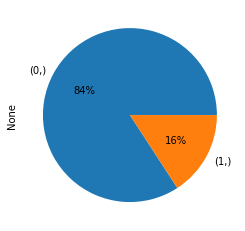

In [12]:
y_train.value_counts().plot(kind='pie', autopct='%1.0f%%');

## Procesar RCC

In [14]:
rcc_train = pd.read_csv(f'{path}/rcc_train.csv')
rcc_test = pd.read_csv(f'{path}/rcc_test.csv')

In [15]:
##### inputar datos faltantes en la base de rcc_test
rcc_test['cod_instit_financiera'].fillna(rcc_test['cod_instit_financiera'].value_counts().index[0], inplace=True)
rcc_test['PRODUCTO'].fillna(rcc_test['PRODUCTO'].value_counts().index[0], inplace=True)

In [16]:
dict_ = {'codmes': 'int32',
 'key_value': 'int32',
 'condicion': 'int32',
 'tipo_credito': 'int32',
 'cod_instit_financiera': 'int32',
 'PRODUCTO': 'int32',
 'RIESGO_DIRECTO': 'int32',
 'COD_CLASIFICACION_DEUDOR': 'int32'}
rcc_train = rcc_train.astype(dict_)
rcc_test = rcc_test.astype(dict_)

In [17]:
##### categorizar la variable condicion
bins = [-1, 0, 10, 20, 30, 60, 90, 180, 360, 720, float("inf")]
rcc_train["condicion"] = pd.cut(rcc_train.condicion, bins)
rcc_train["condicion"] = rcc_train["condicion"].cat.codes
rcc_test["condicion"] = pd.cut(rcc_test.condicion, bins)
rcc_test["condicion"] = rcc_test["condicion"].cat.codes

In [18]:
def get_filter_columns(df):
    keep_columns = set(keep_columns_final).intersection(set(df.columns))
    return df[keep_columns]

In [19]:
### definir las variables que seran agregadas
moda=lambda x: calculate_mode(x)
moda.__name__='mode'
agg_rcc = {'cod_instit_financiera':['nunique','min','max',moda],
           'PRODUCTO':['nunique','min','max',moda],
          }
def get_aggregate(df, desde,n):
    print(f'haciendo aggregate de cod_instit_financiera y Producto desde {desde}')
    df_result = df[df.codmes>=desde].groupby('key_value').agg(agg_rcc)
    df_result.columns = [feature+'_'+agg+f'_ult{n+1}mes' for feature, agg in df_result.columns]    
    df_result = get_filter_columns(df_result)
    gc.collect()  
    return df_result

In [20]:
def get_unstack(df, feature, desde, n, func):
    print(f'haciendo unstack de {feature} desde {desde} con la funcion de agregacion {func}')
    if func =='Sum':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.sum().unstack(level = 1, fill_value=np.nan)
    if func == 'Unique':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.size().unstack(level = 1, fill_value=np.nan)
    if func == 'Min':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.min().unstack(level = 1, fill_value=np.nan)
    if func == 'Max':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.max().unstack(level = 1, fill_value=np.nan)
    if func == 'Std':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.std().unstack(level = 1, fill_value=np.nan)
    if func == 'Mean':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.mean().unstack(level = 1, fill_value=np.nan)
    if func == 'Median':
        df_result = df[df.codmes>=desde].groupby(['key_value', feature]).saldo.median().unstack(level = 1, fill_value=np.nan)
    df_result.columns = [f'{df_result.columns.name}_{value}_saldo{func}_ult{n+1}meses' for value in df_result.columns]
    
    df_result = get_filter_columns(df_result)
    gc.collect()      
    return df_result

In [21]:
rcc_train_list=[]
for n,desde in enumerate(sorted(set(rcc_train.codmes),reverse=True)):
    for feature in ['tipo_credito','RIESGO_DIRECTO','COD_CLASIFICACION_DEUDOR','condicion']:
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Sum'))
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Unique'))
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Min'))
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Max'))
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Std'))
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Mean'))
        rcc_train_list.append(get_unstack(rcc_train, feature, desde, n, 'Median'))
    rcc_train_list.append(get_aggregate(rcc_train, desde,n))

haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Sum
haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Unique
haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Min
haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Max
haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Std
haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Mean
haciendo unstack de tipo_credito desde 201802 con la funcion de agregacion Median
haciendo unstack de RIESGO_DIRECTO desde 201802 con la funcion de agregacion Sum
haciendo unstack de RIESGO_DIRECTO desde 201802 con la funcion de agregacion Unique
haciendo unstack de RIESGO_DIRECTO desde 201802 con la funcion de agregacion Min
haciendo unstack de RIESGO_DIRECTO desde 201802 con la funcion de agregacion Max
haciendo unstack de RIESGO_DIRECTO desde 201802 con la funcion de agregacion Std
haciendo unstack de RIESGO_DIREC

haciendo unstack de RIESGO_DIRECTO desde 201711 con la funcion de agregacion Median
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201711 con la funcion de agregacion Sum
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201711 con la funcion de agregacion Unique
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201711 con la funcion de agregacion Min
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201711 con la funcion de agregacion Max
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201711 con la funcion de agregacion Std
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201711 con la funcion de agregacion Mean
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201711 con la funcion de agregacion Median
haciendo unstack de condicion desde 201711 con la funcion de agregacion Sum
haciendo unstack de condicion desde 201711 con la funcion de agregacion Unique
haciendo unstack de condicion desde 201711 con la funcion de agregacion Min
haciendo unstack de condicion desde 20171

haciendo unstack de condicion desde 201708 con la funcion de agregacion Mean
haciendo unstack de condicion desde 201708 con la funcion de agregacion Median
haciendo aggregate de cod_instit_financiera y Producto desde 201708
haciendo unstack de tipo_credito desde 201707 con la funcion de agregacion Sum
haciendo unstack de tipo_credito desde 201707 con la funcion de agregacion Unique
haciendo unstack de tipo_credito desde 201707 con la funcion de agregacion Min
haciendo unstack de tipo_credito desde 201707 con la funcion de agregacion Max
haciendo unstack de tipo_credito desde 201707 con la funcion de agregacion Std
haciendo unstack de tipo_credito desde 201707 con la funcion de agregacion Mean
haciendo unstack de tipo_credito desde 201707 con la funcion de agregacion Median
haciendo unstack de RIESGO_DIRECTO desde 201707 con la funcion de agregacion Sum
haciendo unstack de RIESGO_DIRECTO desde 201707 con la funcion de agregacion Unique
haciendo unstack de RIESGO_DIRECTO desde 201707 con

haciendo unstack de RIESGO_DIRECTO desde 201704 con la funcion de agregacion Std
haciendo unstack de RIESGO_DIRECTO desde 201704 con la funcion de agregacion Mean
haciendo unstack de RIESGO_DIRECTO desde 201704 con la funcion de agregacion Median
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201704 con la funcion de agregacion Sum
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201704 con la funcion de agregacion Unique
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201704 con la funcion de agregacion Min
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201704 con la funcion de agregacion Max
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201704 con la funcion de agregacion Std
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201704 con la funcion de agregacion Mean
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201704 con la funcion de agregacion Median
haciendo unstack de condicion desde 201704 con la funcion de agregacion Sum
haciendo unstack de condicion des

In [22]:
rcc_train = pd.concat(rcc_train_list, axis=1)
del rcc_train_list

In [23]:
rcc_train.shape

(358487, 774)

In [29]:
rcc_test_list=[]
for n,desde in enumerate(sorted(set(rcc_test.codmes),reverse=True)):
    for feature in ['tipo_credito','RIESGO_DIRECTO','COD_CLASIFICACION_DEUDOR','condicion']:
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Sum'))
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Unique'))
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Min'))
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Max'))
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Std'))
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Mean'))
        rcc_test_list.append(get_unstack(rcc_test, feature, desde, n, 'Median'))
    rcc_test_list.append(get_aggregate(rcc_test, desde,n))

haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Sum
haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Unique
haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Min
haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Max
haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Std
haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Mean
haciendo unstack de tipo_credito desde 201902 con la funcion de agregacion Median
haciendo unstack de RIESGO_DIRECTO desde 201902 con la funcion de agregacion Sum
haciendo unstack de RIESGO_DIRECTO desde 201902 con la funcion de agregacion Unique
haciendo unstack de RIESGO_DIRECTO desde 201902 con la funcion de agregacion Min
haciendo unstack de RIESGO_DIRECTO desde 201902 con la funcion de agregacion Max
haciendo unstack de RIESGO_DIRECTO desde 201902 con la funcion de agregacion Std
haciendo unstack de RIESGO_DIREC

haciendo unstack de RIESGO_DIRECTO desde 201811 con la funcion de agregacion Median
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201811 con la funcion de agregacion Sum
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201811 con la funcion de agregacion Unique
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201811 con la funcion de agregacion Min
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201811 con la funcion de agregacion Max
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201811 con la funcion de agregacion Std
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201811 con la funcion de agregacion Mean
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201811 con la funcion de agregacion Median
haciendo unstack de condicion desde 201811 con la funcion de agregacion Sum
haciendo unstack de condicion desde 201811 con la funcion de agregacion Unique
haciendo unstack de condicion desde 201811 con la funcion de agregacion Min
haciendo unstack de condicion desde 20181

haciendo unstack de condicion desde 201808 con la funcion de agregacion Mean
haciendo unstack de condicion desde 201808 con la funcion de agregacion Median
haciendo aggregate de cod_instit_financiera y Producto desde 201808
haciendo unstack de tipo_credito desde 201807 con la funcion de agregacion Sum
haciendo unstack de tipo_credito desde 201807 con la funcion de agregacion Unique
haciendo unstack de tipo_credito desde 201807 con la funcion de agregacion Min
haciendo unstack de tipo_credito desde 201807 con la funcion de agregacion Max
haciendo unstack de tipo_credito desde 201807 con la funcion de agregacion Std
haciendo unstack de tipo_credito desde 201807 con la funcion de agregacion Mean
haciendo unstack de tipo_credito desde 201807 con la funcion de agregacion Median
haciendo unstack de RIESGO_DIRECTO desde 201807 con la funcion de agregacion Sum
haciendo unstack de RIESGO_DIRECTO desde 201807 con la funcion de agregacion Unique
haciendo unstack de RIESGO_DIRECTO desde 201807 con

haciendo unstack de RIESGO_DIRECTO desde 201804 con la funcion de agregacion Std
haciendo unstack de RIESGO_DIRECTO desde 201804 con la funcion de agregacion Mean
haciendo unstack de RIESGO_DIRECTO desde 201804 con la funcion de agregacion Median
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201804 con la funcion de agregacion Sum
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201804 con la funcion de agregacion Unique
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201804 con la funcion de agregacion Min
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201804 con la funcion de agregacion Max
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201804 con la funcion de agregacion Std
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201804 con la funcion de agregacion Mean
haciendo unstack de COD_CLASIFICACION_DEUDOR desde 201804 con la funcion de agregacion Median
haciendo unstack de condicion desde 201804 con la funcion de agregacion Sum
haciendo unstack de condicion des

In [30]:
rcc_test = pd.concat(rcc_test_list, axis=1)
del rcc_test_list

In [31]:
rcc_test.shape

(396666, 774)

In [32]:
rcc_train, rcc_test = get_keep_columns(rcc_train, rcc_test)

(358487, 774) (396666, 774)
(358487, 774) (396666, 774)


In [33]:
### unir RCC en la base final
train = rcc_train
test = rcc_test
del rcc_train, rcc_test

## Procesar SE

In [34]:
se_train = pd.read_csv(f'{path}/se_train.csv', index_col = 'key_value')
se_test = pd.read_csv(f'{path}/se_test.csv', index_col = 'key_value')

In [35]:
dict_ = {'sexo':'int32',
         'est_cvl':'int32',
         'sit_lab':'int32',
         'cod_ocu':'int32',
         'ctd_hijos':'int32',
         'flg_sin_email':'int32',
         'ctd_veh':'int32',
         'lgr_vot':'int32',
         'prv':'int32',
         'dto':'int32',
         'rgn':'int32',
         'tip_lvledu':'int32'}
se_train = se_train.astype(dict_)
se_test = se_test.astype(dict_)

In [36]:
def get_one_hot(df, feature):
    one_hot = pd.get_dummies(df[feature])
    one_hot.columns = [feature+'_'+str(i) for i in one_hot.columns]
    return one_hot
one_hot_sexo_train = get_one_hot(se_train, 'sexo')
one_hot_sexo_test = get_one_hot(se_test, 'sexo')
one_hot_est_cvl_train = get_one_hot(se_train, 'est_cvl')
one_hot_est_cvl_test = get_one_hot(se_test, 'est_cvl')
one_hot_rgn_train = get_one_hot(se_train, 'rgn')
one_hot_rgn_test = get_one_hot(se_test, 'rgn')

In [37]:
train = train.join(one_hot_sexo_train).join(one_hot_est_cvl_train).join(one_hot_rgn_train).join(se_train[['edad','ctd_veh']])
test = test.join(one_hot_sexo_test).join(one_hot_est_cvl_test).join(one_hot_rgn_test).join(se_test[['edad','ctd_veh']])
del se_train, se_test

In [62]:
del one_hot_sexo_train, one_hot_sexo_test
del one_hot_est_cvl_train, one_hot_est_cvl_test
del one_hot_rgn_train, one_hot_rgn_test

## Procesar SUNAT

In [38]:
sunat_train = pd.read_csv(f'{path}/sunat_train.csv')
sunat_test = pd.read_csv(f'{path}/sunat_test.csv')

In [39]:
### eliminar registros duplicados
sunat_train.drop_duplicates(inplace=True)
sunat_test.drop_duplicates(inplace=True)
sunat_train.shape, sunat_test.shape

((292479, 18), (318821, 18))

In [40]:
dict_ = {'tipcontribuyente': 'int32',
         'tippersona': 'int32',
         'ciiu': 'int32',
         'ubigeo': 'int32',
         'condiciondomicilio': 'int32',
         'estadocontribuyente': 'int32',
         'codvia': 'int32',
         'codzona': 'int32',
         'contabilidad': 'int32',
         'facturacion': 'int32',
         'domiciliado': 'int32',
         'comercioexterior': 'int32',
         'cargorele': 'int32',
         'codentidadtributo': 'int32',
         'estadotributo': 'int32'}
sunat_train = sunat_train.astype(dict_)
sunat_test = sunat_test.astype(dict_)

In [41]:
sunat_train['diff_fech'] = sunat_train['fecbaja'] - sunat_train['fecalta']
sunat_test['diff_fech'] = sunat_test['fecbaja'] - sunat_test['fecalta']

In [42]:
moda=lambda x: calculate_mode(x)
moda.__name__='mode'
agg_sunat = {
            'tipcontribuyente':['nunique',moda],
            'tippersona':['nunique',moda],
            'ciiu':['nunique', moda],
            'ubigeo':['nunique',moda],
           'condiciondomicilio':['nunique',moda],  ####
#            'estadocontribuyente':['nunique',moda],
           'codvia':['nunique',moda],
           'codzona':['nunique',moda],
           'contabilidad':['nunique',moda],
           'facturacion':['nunique',moda],
           'domiciliado':['nunique',moda],
           'comercioexterior':['nunique',moda],
           'cargorele':['nunique',moda],
           'codentidadtributo':['nunique',moda], ####
           'estadotributo':['nunique',moda], ####
           'fecalta':['mean','max', 'nunique','min','std'],
           'fecbaja':['mean','max', 'nunique','min'], 
           'diff_fech':['mean','max', 'nunique','min'], 
            }
sunat_train_agg = sunat_train.groupby('key_value').agg(agg_sunat)
sunat_train_agg.columns = [i+'_'+j for i,j in sunat_train_agg.columns]
sunat_test_agg = sunat_test.groupby('key_value').agg(agg_sunat)
sunat_test_agg.columns = [i+'_'+j for i,j in sunat_test_agg.columns]
# del sunat_train, sunat_test

In [43]:
crosstab_estadocontribuyente_train = get_crosstab(sunat_train, 'key_value', 'estadocontribuyente')
crosstab_estadocontribuyente_test = get_crosstab(sunat_test, 'key_value', 'estadocontribuyente')

In [44]:
train = train.join(crosstab_estadocontribuyente_train).join(sunat_train_agg)
test = test.join(crosstab_estadocontribuyente_test).join(sunat_test_agg)
train, test = get_keep_columns(train, test)
del sunat_train_agg, sunat_test_agg, sunat_train, sunat_test, crosstab_estadocontribuyente_train, crosstab_estadocontribuyente_test

(358487, 847) (396666, 846)
(358487, 846) (396666, 846)


In [45]:
train = get_filter_columns(train)
test = get_filter_columns(test)
train.shape, test.shape

((358487, 810), (396666, 810))

## Aggregate Unstack de cod_instit_financiera and PRODUCTO del ultimo primer, segundo, tercero y doceavo mes

In [47]:
aux_meses =  [(0, 201802, 201902), (1, 201801, 201901), (2, 201712, 201812), (11, 201703, 201803)]
list_rcc_train = []
list_rcc_test = []
for n,desde_train, desde_test in aux_meses:
    rcc_train, rcc_test = get_rcc()

    rcc_train_list = get_rcc_list(rcc_train,desde_train, n)
    rcc_test_list = get_rcc_list(rcc_test,desde_test, n)

    rcc_train = pd.concat(rcc_train_list, axis=1)
    rcc_test = pd.concat(rcc_test_list, axis=1)
    del rcc_train_list, rcc_test_list
    
    rcc_train = get_filter_columns(rcc_train)
    rcc_test = get_filter_columns(rcc_test)
    print(rcc_train.shape, rcc_test.shape)
    
    list_rcc_train.append(rcc_train)
    list_rcc_test.append(rcc_test)

haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Sum
haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Unique
haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Min
haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Max
haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Std
haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Mean
haciendo unstack de cod_instit_financiera desde 201802 con la funcion de agregacion Median
haciendo unstack de PRODUCTO desde 201802 con la funcion de agregacion Sum
haciendo unstack de PRODUCTO desde 201802 con la funcion de agregacion Unique
haciendo unstack de PRODUCTO desde 201802 con la funcion de agregacion Min
haciendo unstack de PRODUCTO desde 201802 con la funcion de agregacion Max
haciendo unstack de PRODUCTO desde 201802 con la funcion de agregacion Std

haciendo unstack de cod_instit_financiera desde 201803 con la funcion de agregacion Unique
haciendo unstack de cod_instit_financiera desde 201803 con la funcion de agregacion Min
haciendo unstack de cod_instit_financiera desde 201803 con la funcion de agregacion Max
haciendo unstack de cod_instit_financiera desde 201803 con la funcion de agregacion Std
haciendo unstack de cod_instit_financiera desde 201803 con la funcion de agregacion Mean
haciendo unstack de cod_instit_financiera desde 201803 con la funcion de agregacion Median
haciendo unstack de PRODUCTO desde 201803 con la funcion de agregacion Sum
haciendo unstack de PRODUCTO desde 201803 con la funcion de agregacion Unique
haciendo unstack de PRODUCTO desde 201803 con la funcion de agregacion Min
haciendo unstack de PRODUCTO desde 201803 con la funcion de agregacion Max
haciendo unstack de PRODUCTO desde 201803 con la funcion de agregacion Std
haciendo unstack de PRODUCTO desde 201803 con la funcion de agregacion Mean
haciendo un

In [48]:
rcc_train = pd.concat(list_rcc_train, axis=1)
rcc_test = pd.concat(list_rcc_test, axis=1)
del list_rcc_train, list_rcc_test
rcc_train.shape, rcc_test.shape

((358487, 818), (396666, 818))

In [49]:
train = train.join(rcc_train)
test = test.join(rcc_test)
del rcc_train, rcc_test 
train.shape, test.shape

((358487, 1628), (396666, 1628))

## Ensamble de modelos - Promedio Simple

In [50]:
from lightgbm import LGBMClassifier
learner_lightgbm = LGBMClassifier(n_estimators=1000, max_depth=6, boosting_type='gbdt', min_child_samples=1000)
learner_lightgbm.fit(train, y_train.target, eval_metric="auc", verbose=True)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=6,
               min_child_samples=1000, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [51]:
from catboost import CatBoostClassifier
learner_catboost = CatBoostClassifier(n_estimators=1000, eval_metric = 'AUC', max_depth = 6)
learner_catboost.fit(train, y_train,  early_stopping_rounds=10, verbose=False)

In [53]:
test_probs_catboost = pd.Series(learner_catboost.predict_proba(test)[:, -1], index=test.index, name="target")
test_probs_lightgbm = pd.Series(learner_lightgbm.predict_proba(test)[:, -1], index=test.index, name="target")
test_probs_mean = test_probs_catboost*0.4 + test_probs_lightgbm*0.6
test_probs_mean.name = 'target'
test_probs_mean.shape

(396666,)

In [60]:
del learner_lightgbm, learner_catboost

## Ensamble de modelos - Stacking

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [17]:
def cross_validation_lightgbm(train, y_train, test):
    folds = [train.index[t] for t, v in KFold(5).split(train)]
    test_probs = []
    train_probs = []
    fi = []
    for i, idx in enumerate(folds):
        print("*"*10, i, "*"*10)
        Xt = train.loc[idx]
        yt = y_train.loc[Xt.index].target

        Xv = train.drop(Xt.index)
        yv = y_train.loc[Xv.index].target

        learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, colsample_bytree=0.8,
                       subsample=0.8, max_bin=200, learning_rate=0.1, random_state=42)

        learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                    eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
        test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
        train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
        fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    train_probs = pd.concat(train_probs)
    fi = pd.concat(fi, axis=1).mean(axis=1)
    print("*" * 21)
    print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
    print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))
    return fi, train_probs, test_probs

In [39]:
fi_lightgbm, train_probs_lightgbm, test_probs_lightgbm = cross_validation_lightgbm(train, y_train, test) ### score de 0.85642 en la tabla publica

In [41]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.fit
def cross_validation_gbc(train, y_train, test):
    folds = [train.index[t] for t, v in KFold(5).split(train)]
    test_probs = []
    train_probs = []
    fi = []
    for i, idx in enumerate(folds):
        print("*"*10, i, "*"*10)
        Xt = train.loc[idx]
        yt = y_train.loc[Xt.index].target

        Xv = train.drop(Xt.index)
        yv = y_train.loc[Xv.index].target

        learner = GradientBoostingClassifier(n_estimators=500, learning_rate=0.3, subsample=0.8,
                                             max_depth=5, verbose=1, max_features=0.82, random_state=42,
                                             n_iter_no_change = 10, tol=0.01, validation_fraction = 0.2)

        learner.fit(Xt, yt)        
        test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
        train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
        fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))
        print('roc_auc_estimado de : ' + str(roc_auc_score(yv, pd.Series(learner.predict_proba(Xv)[:, -1]))))    

    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    train_probs = pd.concat(train_probs)
    fi = pd.concat(fi, axis=1).mean(axis=1)
    print("*" * 21)
    print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
    print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  
    return fi, train_probs, test_probs

In [42]:
fi_lightgbm, train_probs_lightgbm, test_probs_lightgbm = cross_validation_gbc(train, y_train, test)

In [18]:
def cross_validation_lightgbm_cf(train, y_train, test):
    var_categ = [c for c in train.columns if 'mode' in c]
    for c in var_categ:
        train[c] = train[c].astype('category')
        test[c] = test[c].astype('category')

    folds = [train.index[t] for t, v in KFold(5).split(train)]
    test_probs = []
    train_probs = []
    fi = []
    for i, idx in enumerate(folds):
        print("*"*10, i, "*"*10)
        Xt = train.loc[idx]
        yt = y_train.loc[Xt.index].target

        Xv = train.drop(Xt.index)
        yv = y_train.loc[Xv.index].target

        learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, colsample_bytree=0.8,
                       subsample=0.8, max_bin=200, learning_rate=0.1, random_state = 42)

        learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                    eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
        test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
        train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
        fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    train_probs = pd.concat(train_probs)
    fi = pd.concat(fi, axis=1).mean(axis=1)
    print("*" * 21)
    print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
    print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))
    return fi, train_probs, test_probs

In [43]:
fi_lightgbm_cf, train_probs_lightgbm_cf, test_probs_lightgbm_cf = cross_validation_lightgbm_cf(train, y_train, test)

In [19]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
def cross_validate_learning_rate(estimator, x_train, y_train, cv = 5, scoring = 'roc_auc', return_train_score = True):
    results = cross_validate(estimator,
                            x_train,
                            y_train,
                            cv = cv,
                            scoring=scoring,
                            return_train_score = return_train_score ) 
    train_scores = results['train_score']
    test_scores = results['test_score']
    print("train_scores: {}".format(np.mean(train_scores)))
    print("test_scores: {}".format(np.mean(test_scores)))

    lc = learning_curve(estimator, 
                        x_train, 
                        y_train, 
                        cv=cv, 
                        scoring=scoring)
    samples, train, test = lc[0],lc[1],lc[2]
    plt.plot(samples, np.mean(train, axis=1))
    plt.plot(samples, np.mean(test, axis=1))

In [20]:
from sklearn.model_selection import GridSearchCV
def grid_search_param(X, y,nfolds, param_grid, model_sklearn, scoring = 'roc_auc'):
    grid_search = GridSearchCV(model_sklearn, param_grid, cv=nfolds, return_train_score=True, scoring=scoring)
    grid_search.fit(X, y)
    return grid_search

In [30]:
train_probs_lightgbm = pd.read_pickle('train_probs_lightgbm.pkl')
train_probs_lightgbm_cf = pd.read_pickle('train_probs_lightgbm_cf.pkl')
train_probs_gbc = pd.read_pickle('train_probs_gbc.pkl')
test_probs_lightgbm = pd.read_pickle('test_probs_lightgbm.pkl')
test_probs_lightgbm_cf = pd.read_pickle('test_probs_lightgbm_cf.pkl')
test_probs_gbc = pd.read_pickle('test_probs_gbc.pkl')

In [32]:
train_probs_total = pd.concat([train_probs_lightgbm,train_probs_lightgbm_cf, train_probs_gbc], axis=1)
test_probs_total =  pd.concat([test_probs_lightgbm,test_probs_lightgbm_cf, test_probs_gbc], axis=1)
train_probs_total.columns = ['probs_lightgbm', 'probs_lightgbm_cf', 'probs_gbc']
test_probs_total.columns = ['probs_lightgbm', 'probs_lightgbm_cf', 'probs_gbc']

In [33]:
display(train_probs_total.corr(), test_probs_total.corr())

,probs_lightgbm,probs_lightgbm_cf,probs_gbc
probs_lightgbm,1.000000,0.982945,0.949030
probs_lightgbm_cf,0.982945,1.000000,0.946052
probs_gbc,0.949030,0.946052,1.000000


,probs_lightgbm,probs_lightgbm_cf,probs_gbc
probs_lightgbm,1.000000,0.992691,0.972856
probs_lightgbm_cf,0.992691,1.000000,0.971039
probs_gbc,0.972856,0.971039,1.000000


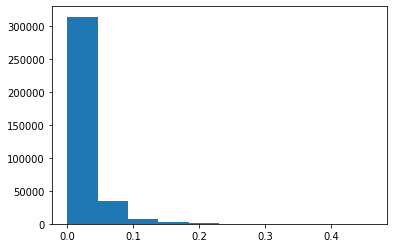

In [34]:
import matplotlib.pyplot as plt
plt.hist(np.std(train_probs_total.values, axis=1));

train_scores: 0.8548033944986309
test_scores: 0.854759582575209


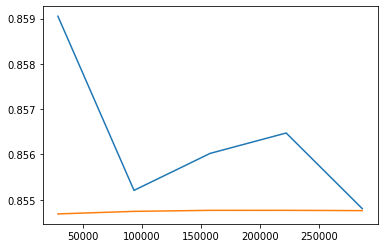

In [35]:
from sklearn.linear_model import LogisticRegression
### definir los parametros a tunear
train = train
Cs = [0.1, 0.3, 0.8, 0.9, 1.0]
# https://neurtu.readthedocs.io/examples/logistic_regression_scaling.html
solvers = ['lbfgs','saga','newton-cg','sag'] # newton-cg, sag, lbfgs, liblinear, saga
param_grid = {'C': Cs,'solver':solvers}
### encontrando los hiper_parámetros
fitting=grid_search_param(train_probs_total, y_train.target, 5,param_grid, LogisticRegression(penalty="l2", tol=0.0001, random_state=42), scoring='roc_auc')
### instanciar el estimador
estimator = fitting.best_estimator_
#     print(estimator)
### aplicar cross_validate y learning_rate 
cross_validate_learning_rate(estimator, train_probs_total, y_train.target, scoring='roc_auc')

In [36]:
print(estimator)

LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)


In [37]:
estimator.coef_

array([[ 4.10014634,  2.62920487, -0.14486534]])

In [38]:
test_stacking = pd.Series(estimator.predict_proba(test_probs_total)[:,-1], index=test.index, name = 'target')
test_stacking

key_value
0         0.045273
1         0.060139
2         0.053343
3         0.584437
4         0.104742
            ...   
396661    0.068148
396662    0.163139
396663    0.188631
396664    0.058015
396665    0.053967
Name: target, Length: 396666, dtype: float64

In [40]:
test_stacking.to_csv('../results/stacking_2models_lgbm2_score_0.85488.csv') ### score de 0.85704 en la tabla publica

## Promedio Final

In [44]:
test_probs_mean_total = test_probs_mean*0.4 + test_stacking*0.6
test_probs_mean_total

In [45]:
test_probs_mean_total.to_csv("../results/emsamble_simple_and_stacking_v6.csv") ### score de 0.85732  en la tabla publica

In [ ]:
#### entrando all_training con las 1628 features y luego con 700 features, para obtener dos test_probs_mean. 
#### se promedian ambos resultados y se obtiene despues del promedio final
#### se mejora el score de 0.85732 a 0.85747 en la tabla publica